In [27]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import glob
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND 
from rnn.model import Attention
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [28]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.nanmean(losses)

def evaluate(model, ldr, preproc, store_prediction=False, print_prediction=False):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    if store_prediction:
        with open("test_results.json", "w") as res:
            json.dump(results, res)

    if print_prediction:
        for (truth, pred) in results:
            print('True label:\n  ', end="")
            for char in truth:
                print(char, end=" ")
            print('\nPredicted labal:\n  ', end="")
            for char in pred:
                print(char, end=" ")
            print('')

    return np.nanmean(losses), compute_wer(results)

In [29]:
#Loading

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

data_cfg = config["data"]
opt_cfg = config["optimizer"]

start = time.time()
preproc = Preprocessor(data_cfg["all_data"], start_and_end=data_cfg["start_and_end"])
print("Preprocessing finished", time.time() - start, "seconds elapsed")

start = time.time()
train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
print("Train Loaded", time.time() - start, "seconds elapsed")   

start = time.time()    
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])
print("Dev Loaded", time.time() - start, "seconds elapsed")

start = time.time()
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])
print("Test Loaded", time.time() - start, "seconds elapsed")

Preprocessing finished 22.297833919525146 seconds elapsed
Train Loaded 2103.7778820991516 seconds elapsed
Dev Loaded 305.34986543655396 seconds elapsed
Test Loaded 619.65385389328 seconds elapsed


In [30]:
#Training
# Reload config if changed epoch
with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)
model_cfg = config["model"]
opt_cfg = config["optimizer"]
print("max epochs:", opt_cfg["max_epochs"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
print("------------")

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 512)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])
#change this
mslst = [int(y) for y in [50 * (2 ** x) for x in range(20)] if y < opt_cfg["max_epochs"]]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mslst, gamma=0.1)

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
losses = []
weres = []


best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    scheduler.step()

    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)    
    losses.append(dev_loss)
    weres.append(dev_wer)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    for param_group in optimizer.param_groups:
        print('...learning rate: ' + str(param_group['lr']))

    torch.save(model, os.path.join(config["save_path"], str(ep)))   
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

max epochs: 100
Training RNN
------------
epoch    1 | train_loss=241.26, dev_loss=228.88 with  96.22% WER (190.21s elapsed)
...learning rate: 0.1
epoch    2 | train_loss=221.15, dev_loss=201.70 with 611.39% WER (220.73s elapsed)
...learning rate: 0.1
epoch    3 | train_loss=215.56, dev_loss=170.74 with 264.12% WER (220.34s elapsed)
...learning rate: 0.1
epoch    4 | train_loss=210.16, dev_loss=166.33 with  95.93% WER (194.10s elapsed)
...learning rate: 0.1
epoch    5 | train_loss=208.96, dev_loss=153.40 with 353.78% WER (220.45s elapsed)
...learning rate: 0.1
epoch    6 | train_loss=205.20, dev_loss=149.01 with 152.72% WER (220.18s elapsed)
...learning rate: 0.1
epoch    7 | train_loss=202.89, dev_loss=137.41 with 119.79% WER (211.86s elapsed)
...learning rate: 0.1
epoch    8 | train_loss=200.40, dev_loss=133.20 with 112.71% WER (210.97s elapsed)
...learning rate: 0.1
epoch    9 | train_loss=197.87, dev_loss=130.63 with 502.33% WER (221.04s elapsed)
...learning rate: 0.1
epoch   10 | 

KeyboardInterrupt: 

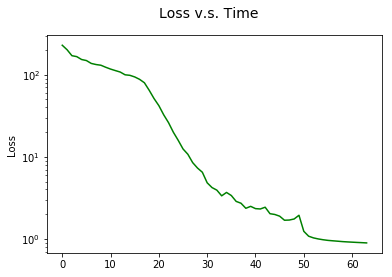

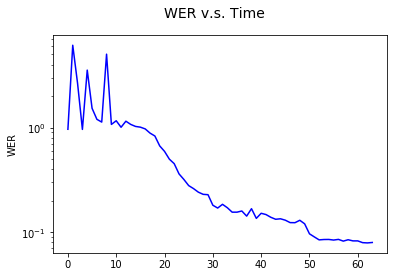

In [31]:
eps = list(range(opt_cfg["max_epochs"]))
'''
fig, ax1 = plt.subplots()
plt.suptitle("Loss & WER v.s. Time", fontsize=14)
ax2 = ax1.twinx()
ax1.plot(eps[:61], losses[:61], 'green')
ax2.plot(eps[:61], weres[:61], 'blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='green')
ax2.set_ylabel('WER', color='blue')
'''
plt.suptitle("Loss v.s. Time", fontsize = 14)
plt.plot(eps[:64], losses[:64], 'green')
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

plt.suptitle("WER v.s. Time", fontsize = 14)
plt.plot(eps[:64], weres[:64], 'blue')
plt.ylabel("WER")
plt.yscale("log")
plt.show()

In [32]:
#Testing

print("Testing RNN")
print("-------------")

test_model = torch.load(os.path.join(config["save_path"], "best"))
_, test_wer = evaluate(test_model, test_ldr, preproc, store_prediction=True, print_prediction=True)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
-------------


D:\TTIC-31110-Final-Project\rnn\model.py:181: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  x, h = self.enc_rnn(x)
D:\TTIC-31110-Final-Project\rnn\model.py:210: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)
D:\TTIC-31110-Final-Project\rnn\model.py:232: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)


True label:
  tai4 kong1 chuan2 san1 bai3 liu4 shi2 du4 fan1 zhuan3 yao2 huang4 wo3 gong1 su1 he2 fu2 rui4 qu1 shao4 xiao4 xiang4 fu2 biao1 shi4 de5 bei4 shuai3 lai2 shuai3 qu4 
Predicted labal:
  tai4 kong1 chuan2 san1 bai3 liu4 shi2 du4 fan1 zhuan3 yao2 huang4 wo3 gong1 su1 he2 fu2 rui4 qu1 shao4 xiao4 xiang4 fu2 biao1 shi4 de5 bei4 shuai3 lai2 shuai3 qu4 
True label:
  ta1 ceng1 ceng1 ceng1 pao3 shang4 lou2 you4 mei2 dai4 jia1 li5 yao4 shi5 you4 ti1 you4 chuai4 you4 zhuang4 men2 ye3 da3 bu4 kai1 
Predicted labal:
  ta1 ceng2 ceng1 ceng1 pao3 shang4 lou2 you4 mei2 dai4 jia1 li5 yao4 shi5 you4 ti1 you4 chuai4 you4 zhuang4 men2 ye3 da3 bu4 kai1 
True label:
  gong4 he2 dang3 ye3 hao2 bu4 shi4 ruo4 qiang2 diao4 reng2 yao4 ba3 ping2 heng2 yu4 suan4 wen4 ti2 yu3 zheng4 fu3 lin2 shi2 bo1 kuan3 gua4 gou1 zai4 ci4 po4 shi3 bai2 gong1 rang4 bu4 
Predicted labal:
  gong4 he2 dang3 ye3 hao2 bu4 shi4 ruo4 qiang2 diao4 reng2 yao4 ba3 ping2 heng2 yu4 suan4 wen4 ti2 yu3 zheng4 fu3 lin2 shi2 bo1 kua

  yong4 chuan2 tong3 de5 chang2 gui1 yu4 yang1 fang1 shi4 mei3 yu4 yi1 mu3 yang1 miao2 zhi3 ke3 zai1 cha1 ba1 mu3 da4 tian2 di3 mo2 yu4 yang1 ze2 ke3 yi2 zai1 wu3 shi2 mu3 
True label:
  ta1 qiong2 zhui1 bu4 she3 shen1 wa1 xi4 cha2 zhong1 yu2 nong4 qing1 bei4 gao4 yu3 gai1 nai3 niu2 zhan4 shi4 liang3 kuai4 pai2 zi5 yi1 tao4 ban1 zi5 
Predicted labal:
  ta1 qiong2 zhui1 bu4 she3 shen1 wa1 xi4 cha2 zhong1 yu2 nong4 qing1 bei4 gao4 yu3 gai1 nai3 niu2 zhan4 shi4 liang3 kuai4 pai2 zi5 yi1 tao4 ban1 zi5 
True label:
  ge4 qu1 fu4 ze2 ge4 qu1 de5 ye4 wu4 zhi2 you3 si3 wang2 zai4 bie2 qu1 de5 ren2 cai2 yun2 xu3 shi3 yong4 bie2 qu1 de5 bin4 yi2 guan3 
Predicted labal:
  na4 zhi1 fu2 chi2 le5 de5 wu4 zi1 bao1 quan2 wu3 pin3 bie2 jian4 she4 de5 ren2 yuan2 de5 ren2 cai2 yue4 de5 ren2 cai2 yue4 jing1 diu1 pin3 ye3 shi4 yi2 kuai4 ji2 yu3 
True label:
  liu2 ji1 song1 yuan2 shi4 qin1 zhou1 di4 qu1 de5 qin1 zhou1 shi4 zhang3 di4 qu1 che4 xian4 jian4 shi4 hou4 gai3 ren4 qin1 zhou1 shi4 de5 qin1 bei3 qu

  ju4 ren4 wei2 a1 yu4 wang2 yu2 gong1 yuan2 qian2 er4 si4 jiu3 nian2 jian4 zai4 lan2 pi2 ni2 de5 zhe4 gen1 shi2 zhu4 shi4 ta1 yong4 lai2 biao1 zhi4 shi4 jia1 mou2 ni2 dan4 sheng1 chu4 de5 
True label:
  zao3 bei4 guo2 wai4 nong2 hu4 guang3 fan4 cai3 yong4 de5 wei1 sheng1 wu4 jun1 yang3 qin2 chu4 ji4 shu4 yi3 luo4 hu4 zhong1 guo2 
Predicted labal:
  zao3 bei4 guo2 wai4 nong2 hu4 guang3 fan4 cai3 yong4 de5 wei1 sheng1 wu4 jun1 yang3 qin2 chu4 ji4 shu4 yi3 luo4 hu4 zhong1 guo2 
True label:
  qi2 bi3 mo4 chuan2 shen2 qi4 yun4 yu3 mo4 yun4 he2 yi1 ji3 zhi4 xin1 miao4 tan4 yu2 fa3 mo4 qu3 jin4 yu2 xin1 de5 jing4 jie4 
Predicted labal:
  qi2 bi3 mo4 chuan2 shen2 qi4 yun4 yu3 mo4 yun4 he2 yi1 ji3 zhi4 xin1 miao4 tan4 yu2 fa3 mo4 qu3 jin4 yu2 xin1 de5 jing4 jie4 
True label:
  ku1 kou3 kang1 fu1 shi4 xiang1 xiang1 zi3 mei4 de5 mu3 qin1 bin1 ye3 bai3 he2 de5 mei4 fu5 si4 shi2 qi1 sui4 le5 tou2 fa5 xi1 bo2 dan4 yin1 wei4 you3 yi1 zhang1 wa2 wa5 lian3 kan4 qi3 lai5 hai2 hen3 nian2 qing1 
Predicte

  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
True label:
  min2 yong4 hang2 kong1 qi4 di3 ya1 quan2 shi4 yong4 min2 yong4 hang2 kong1 qi4 guo2 ji2 deng1 ji4 guo2 fa3 lv4 
Predicted labal:
  min2 yong4 hang2 kong1 qi4 di3 ya1 quan2 shi4 yong4 min2 yong4 hang2 kong1 qi4 guo2 ji2 deng1 ji4 guo2 fa3 lv4 
True label:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
Predicted labal:
  wo3 wai4 you3 zhuan1 jia1 tan2 dao4 chang3 er4 da4 ming2 chan3 yong4 ka3 de5 yan2 shou4 gai1 yi4 wu2 yi4 tou2 xing2 chun1 fen1 shi2 da4 liang4 lao3 hong2 yong3 lin2 reng2 zuo4 zuo4 zuo5 
True label:
  jian4 yuan2 zhi4 jin1 yi2 you3 lu4 da4 er3 yang2 kong3 que4 deng3 zai4 zhe4 li3 sheng1 er2 yu4 nv3 liang3 qian1 duo1 tou2 
Predicted labal:
  ji

  fou3 ze2 guang1 you3 chan3 liang4 xiao1 bu4 chu1 qu4 ku4 cun2 yue4 lai2 yue4 duo1 wai4 qian4 huo4 kuan3 yue4 lai2 yue4 duo1 liu2 dong4 zi1 jin1 jiu4 hui4 yue4 lai2 yue4 shao3 
True label:
  xin1 hua2 she4 bo1 en1 yi1 yue4 san1 ri4 xiao1 xi5 xi1 de2 ren2 lei4 xue2 jia1 jing1 kao2 gu3 fa1 xian4 yuan3 zai4 shi2 qi4 shi2 dai4 de5 ren2 jiu4 huan4 you3 ai2 zheng4 
Predicted labal:
  xin1 hua2 she4 bo1 en1 yi1 yue4 san1 ri4 xiao1 xi5 xi1 de2 ren2 lei4 xue2 jia1 jing1 kao2 gu3 fa1 xian4 yuan3 zai4 shi2 qi4 shi2 dai4 de5 ren2 jiu4 huan4 you3 ai2 zheng4 
True label:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao4 mei3 de5 mian4 rong2 
Predicted labal:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao4 mei3 de5 mian4 rong2 
True label:
  wu4 bi4 shi3 jiao4 mai4 rou2 he2 you3 yun4 bu4 neng2 ye3 diao4 wu2 qiang1 rang4 wai4 guo2 ren2 yi3 wei2 lun2 dun1 zhu4 de5 dou1 shi4 feng1 zi5 
Predicted labal:
  wu4 bi4 s

  dan4 ge2 ming4 gao3 jian4 she4 dou1 yao4 you3 yi4 pi1 yong3 yu2 si1 kao3 yong3 yu2 tan4 suo3 yong3 yu2 chuang4 xin1 de5 chuang3 jiang4 
True label:
  kao4 ren2 min2 qun2 zhong4 wa1 dao4 gou1 bai2 tian1 di2 wei3 jun1 ya1 zhi4 lao2 bai3 xing4 tian2 ping2 ye4 wan3 qun2 zhong4 zi4 dong4 wa1 tong1 
Predicted labal:
  kao4 ren2 min2 qun2 zhong4 wa1 dao4 gou1 bai2 tian1 di2 wei3 jun1 ya1 zhi4 lao2 bai3 xing4 tian2 ping2 ye4 wan3 qun2 zhong4 zi4 dong4 wa1 tong1 
True label:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
Predicted labal:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
True label:
  zhan3 wang4 yi1 jiu3 jiu3 liu4 nian2 quan2 heng2 ao4 men2 nei4 wai4 zhu1 duo1 you3 li4 yin1 su4 yu3 bu2 li4 yin1 su4 you3 li4 yin1 su4 shang4 zhan4 you3 li4 di4

  cong2 ning2 bo1 mai3 lai2 de5 bi3 sai4 yong4 qiu2 jing4 you3 duo1 ban4 shi4 xun4 lian4 yong4 qiu2 tan2 xing4 he2 nai4 jiu3 xing4 dou1 nan2 yi3 da2 dao4 bi3 sai4 yao1 qiu2 
Predicted labal:
  cong2 ning2 bo1 mai3 lai2 de5 bi3 sai4 yong4 qiu2 jing4 you3 duo1 ban4 shi4 xun4 lian4 yong4 qiu2 tan2 xing4 he2 nai4 jiu3 xing4 dou1 nan2 yi3 da2 dao4 bi3 sai4 yao1 qiu2 
True label:
  tiao4 wang4 che1 chuang1 wai4 yong4 nin2 de5 li2 jie3 he2 wo3 men5 de5 shuang1 shou3 gong4 jian4 tong1 xiang4 ao4 yun4 de5 dong1 san1 huan2 biao1 yu3 ying4 ru4 yan3 lian2 
Predicted labal:
  xiao3 ao4 che1 chuang1 wai4 yong4 nin2 de5 li2 jie3 he2 wo3 men5 de5 shuang1 shou3 gong4 jian4 tong1 xiang4 ao4 yun4 de5 dong1 san1 huan2 biao1 yu3 ying4 ru4 yan3 lian2 
True label:
  qin1 ying1 de5 bei3 ai4 er3 lan2 xin1 jiao4 pai4 wu3 zhuang1 shi2 er4 ri4 wan3 fa1 biao3 sheng1 ming2 wei1 xie2 yao4 bao4 fu5 ai4 er3 lan2 gong4 he2 jun1 
Predicted labal:
  qin1 ying1 de5 bei3 ai4 er3 lan2 xin1 jiao4 pai4 wu3 zhuang1 shi2 er4 ri

  qi2 zhong1 san1 shi2 hao4 ju1 min2 shao4 tao2 a1 po2 dang1 chang3 bei4 ya1 si3 ran2 hou4 you4 xiong1 hen3 de5 pu1 xiang4 bei3 yuan2 jiu3 jia1 dong1 lou2 
True label:
  ci3 wai4 hai2 li4 yong4 zhe4 ceng2 qin1 yuan2 guan1 xi5 wen3 ding4 ben2 chang3 suo3 xu1 gang1 zha1 kuang4 zha1 lai2 yuan2 
Predicted labal:
  ci3 wai4 hai2 li4 yong4 zhe4 ceng2 qin1 yuan2 guan1 xi5 wen3 ding4 ben2 chang3 suo3 xu1 gang1 zha1 kuang4 zha1 lai2 yuan2 
True label:
  kai1 luan2 kuang4 wu4 ju2 hou4 lv3 jia1 tuo2 kuang4 zhang1 wen2 you3 zhang1 wen2 fu4 liang3 xiong1 di4 tong2 chao1 chan3 tong2 li4 gong1 tong2 dang1 lao2 dong4 mo2 fan4 
Predicted labal:
  kai1 luan2 kuang4 wu4 ju2 hou4 lv3 jia1 tuo2 kuang4 zhang1 wen2 you3 zhang1 wen2 fu4 liang3 xiong1 di4 tong2 chao1 chan3 tong2 li4 gong1 tong2 dang1 lao2 dong4 mo2 fan4 
True label:
  an1 di4 si1 ji2 tuan2 you2 bo1 li4 wei2 ya4 ge1 lun2 bi3 ya4 e4 gua1 duo1 er3 bi4 lu3 he2 wei3 nei4 rui4 la1 wu3 guo2 zu3 cheng2 
Predicted labal:
  an4 di4 si1 ji2 tuan2 you2 bo

  liu4 sheng3 qu1 jun1 wei2 huang2 tu3 gao1 yuan2 qu1 shen1 shan1 qu1 huang1 mo4 qu1 he2 gao1 han2 shan1 qu1 zi4 ran2 tiao2 jian4 e4 lie4 zai1 hai4 pin2 fan2 
True label:
  wo3 ai4 hua1 ai4 zi4 ran2 jie4 de5 hua1 geng4 ai4 yong4 ge4 zhong3 wen2 yi4 xing2 shi4 su4 zao4 pei2 yu4 de5 sheng1 ming4 sheng1 huo2 de5 hua1 you3 yi4 de5 hua1 
Predicted labal:
  wo3 ai4 hua1 ai4 zi4 ran2 jie4 de5 hua1 geng4 ai4 yong4 ge4 zhong3 wen2 yi4 xing2 shi4 su4 zao4 pei2 yu4 de5 sheng1 ming4 sheng1 huo2 de5 hua1 you3 yi4 de5 hua1 
True label:
  ming2 hong2 xiao3 fo2 lia3 wei4 nv2 you3 ji1 hu1 da4 jing1 shi1 se4 wo3 ye3 jing1 de5 fei1 tong2 xiao2 ke3 zen3 me5 na4 zhe4 fan4 sha2 cuo4 wu4 le5 
Predicted labal:
  ming2 hong2 xiao3 fo2 lia3 wei4 nv2 you3 ji1 hu1 da4 jing1 shi1 se4 wo3 ye3 jing1 de5 fei1 tong2 xiao2 ke3 zen3 me5 na4 zhe4 fan4 sha2 cuo4 wu4 le5 
True label:
  yao4 zhi1 dao4 ji2 xing4 xin1 ji1 geng3 se4 shi4 bi4 xu1 zhu4 yuan4 zhi4 liao2 de5 dao4 yi1 yuan4 yue4 zao3 yue4 hao3 yue4 wan3 si3 wang2 l

  gen1 ju4 cun1 gui1 min2 yue1 ou1 da3 nve4 dai5 lao3 ren2 de5 wang2 mou3 er2 xi2 bei4 chu4 er4 bai3 yuan2 fa2 kuan3 bing4 jiao1 yi1 liao2 fei4 wu2 bai3 yuan2 
Predicted labal:
  an4 fa1 chu1 yi3 wei2 yi4 ying1 gai1 yan2 ren2 ba3 deng1 shang4 an4 qu4 wan1 zhe5 gong1 nu3 jian4 tou2 hua4 yan2 bo2 de5 ji2 shou1 xia4 lai5 an1 xi1 ming2 tian1 zai4 ban1 wan4 yuan2 
True label:
  dang1 chuan2 wang3 xia4 piao1 shi2 bai2 chun2 lu4 yang2 qi3 si4 ti2 zai4 an4 bian1 zhui1 sui2 hao3 xiang4 shi4 song4 xing2 yi4 zhi2 pao3 le5 shi2 ji3 li3 tai4 qin1 qie4 le5 
Predicted labal:
  dang1 chuan2 wang3 xia4 piao1 shi2 bai2 chun2 lu4 yang2 qi3 si4 ti2 zai4 an4 bian1 zhui1 sui2 hao3 xiang4 shi4 song4 xing2 yi4 zhi2 pao3 le5 shi2 ji3 li3 tai4 qin1 qie4 le5 
True label:
  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia4 you2 pao3 you4 pu1 dao4 xia4 you2 gang1 qi3 de5 bo1 lang4 shang4 
Predicted labal:
  ta1 men5 cong2 an4 bian1 pa2 qi3 lai5 hun2 shen1 shui3 lin2 lin2 de5 wang3 xia

  zai4 lun2 nuo4 ke4 si1 da4 dao4 yi4 bai3 si4 shi2 wu3 hao4 jie1 jiao3 bian1 yi2 ge4 bai3 you2 lan2 qiu2 chang3 yi2 dai4 lan2 qiu2 ju4 xing1 zhang1 bo2 lun2 ou1 wen2 zha1 ba1 jiu4 zai4 zhe4 li3 dan4 sheng1 
Predicted labal:
  zai4 lun2 nuo4 ke4 si1 da4 dao4 yi4 bai3 si4 shi2 wu3 hao4 jie1 jiao3 bian1 yi2 ge4 bai3 you2 lan2 qiu2 chang3 yi2 dai4 lan2 qiu2 ju4 xing1 zhang1 bo2 lun2 ou1 wen2 zha1 ba1 jiu4 zai4 zhe4 li3 dan4 sheng1 
True label:
  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
Predicted labal:
  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
True label:
  xian1 shui3 yan2 zhi4 fei1 ma2 zu3 yan2 chang2 da2 shi2 hua2 li3 de5 shan1 ya2 dong4 xue2 li3 you3 chun1 qiu1 zhan4 guo2 shi2 qi1 gu3 yue4 zu2 ya2 mu4 qun

  hui2 dao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 qi4 da4 yi4 dian3 de5 yi2 ge4 wa2 er5 zai4 tang2 wu1 di4 shang4 pa2 
Predicted labal:
  hu2 yao4 jia1 huang2 niang2 niang5 de5 nai3 wa2 er5 zheng4 ku1 de5 si1 sheng1 ya3 qi4 da4 yi4 dian3 de5 yi2 ge4 wa2 er5 zai4 tang2 wu1 di4 shang4 pa2 
True label:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
Predicted labal:
  zai4 qian2 yang2 xian4 nong2 min2 quan2 guo2 lao2 mo2 qin1 wan4 you3 de5 yuan2 yi4 chang3 kan4 dao4 si4 qian1 mu3 gan1 ju2 lin2 zai4 yan4 yang2 xia4 lv4 zhi1 yao2 ye4 xu2 bu4 zhang3 zan4 bu4 jue2 kou3 
True label:
  ta1 sui1 ran2 zi4 ji3 bing4 bu4 kan4 jian4 zhuang1 le5 zen3 yang4 de5 lian3 dan4 ci3 shi2 que4 jue2 de5 hen3 ju2 cu4 zui3 chun2 wei1 wei1 yi2 dong4 you4 yao2 yi5 yao2 tou2 
Predicted labal:
  tang2 xuan2 zi4 ji3 bing4 bu4 kan

  jing1 cha2 ming2 mo4 yong3 ji4 gong4 fei1 fa3 yin4 shua1 tu2 shu1 yi4 bai2 wu3 shi2 si4 zhong3 jin4 er4 bai3 ling2 si4 wan4 ce4 fei1 fa3 jing1 ying2 e2 da2 er4 bai3 er4 shi5 ba1 wan4 duo1 yuan2 
True label:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
Predicted labal:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
True label:
  zheng4 yin1 wei4 ci3 si1 nuo4 ceng2 gan3 chu4 po1 shen1 de5 shuo1 lu3 xun4 sui1 shen1 cai2 shou4 ruo4 ai2 xiao3 dan4 he2 lu3 xun4 zai4 yi4 qi3 ni3 bi4 xu1 yang3 shi4 zhe5 qu4 ling3 hui4 na4 chong2 gao1 de5 si1 xiang3 
Predicted labal:
  zheng4 yin1 wei4 ci3 si1 nuo4 ceng2 gan3 chu4 po1 shen1 de5 shuo1 lu3 xun4 sui1 shen1 cai2 shou4 ruo4 ai2 xiao3 dan4 he2 lu3 xun4 zai4 yi4 qi3 ni3 bi4 xu1 yang3 shi4 zhe5 

  ta1 ren4 wei2 si1 chou2 zhi1 lu4 shang4 de5 min2 ge1 hen3 you3 te4 se4 yin1 wei4 de5 li3 wei4 zhi5 heng2 kua4 ou1 ya4 da4 lu4 shi4 ji2 te4 shu1 de5 kua4 guo2 ji2 min2 ge1 
Predicted labal:
  ta1 ren4 wei2 si1 chou2 zhi1 lu4 shang4 de5 min2 ge1 hen3 you3 te4 se4 yin1 wei4 de5 li3 wei4 zhi5 heng2 kua4 ou1 ya4 da4 lu4 shi4 ji2 te4 shu1 de5 kua4 guo2 ji2 min2 ge1 
True label:
  ni3 men5 da4 jia1 chi1 cang1 ying5 wo3 ye3 gen1 zhe5 chi1 cang1 ying5 ni3 men5 yuan4 yi4 chi1 wen2 zi5 wo3 jiu4 gen1 zhe5 chi1 wen2 zi5 shen2 me5 shi4 bu2 yong4 wen4 wo3 
Predicted labal:
  ni3 men5 da4 jia1 chi1 cang1 ying5 wo3 ye3 gen1 zhe5 chi1 cang1 ying5 ni3 men5 yuan4 yi4 chi1 wen2 zi5 wo3 jiu4 gen1 zhe5 chi1 wen2 zi5 shen2 me5 shi4 bu2 yong4 wen4 wo3 
True label:
  wo3 xin1 li3 yi2 zhen4 tan3 te4 xiang3 xiang4 gai1 zen3 yang4 cai2 fang3 ban4 ye4 yong4 ya2 shua1 bing3 chuo1 ren2 jia5 yan3 jing5 de5 ren2 bu4 ceng2 you3 guo4 ban4 dian3 jing1 yan4 
Predicted labal:
  wo3 xin1 li3 yi2 zhen4 tan3 te4 xiang3 xiang

  ri4 ben3 dui4 zai4 nan2 zi3 tuan2 ti3 sai4 zhong1 huo4 yin2 pai2 dui4 yuan2 yan2 jing3 zhe2 xian2 zai4 ge4 ren2 quan2 neng2 sai4 ye3 duo2 de2 yi4 mei2 yin2 pai2 
True label:
  yin2 hang2 cheng2 dui4 hui4 piao4 de5 cheng2 dui4 shen1 qing3 ren2 ying1 yu2 yin2 hang2 cheng2 dui4 hui4 piao4 dao4 qi1 qian2 jiang1 piao4 kuan3 zu2 e2 jiao1 cun2 qi2 kai1 hu4 yin2 hang2 
Predicted labal:
  yi4 hang2 cheng2 dui4 hui4 piao4 de5 cheng2 dui4 shen1 qing3 ren2 ying1 yu2 yin2 hang2 cheng2 dui4 hui4 piao4 dao4 qi1 qian2 jiang1 piao4 kuan3 zu2 e2 jiao1 cun2 qi2 kai1 hu4 yin2 hang2 
True label:
  pang2 tai4 tai5 yi2 lu4 xiao4 zhe5 zou3 lai2 kai1 chuang1 wu2 yuan2 wu2 gu4 chao2 wai4 kan4 yi5 kan4 xiu4 yi1 xiu4 jiang1 yi1 zhi3 yong4 guo4 de5 ya2 qian1 diu1 chu1 qu4 
Predicted labal:
  pang2 tai4 tai5 yi2 lu4 xiao4 zhe5 zou3 lai2 kai1 chuang1 wu2 yuan2 wu2 gu4 chao2 wai4 kan4 yi5 kan4 xiu4 yi1 xiu4 jiang1 yi1 zhi3 yong4 guo4 de5 ya2 qian1 diu1 chu1 qu4 
True label:
  zai4 sou1 cha2 guo4 cheng2 zhong1 mei3 

  ai4 sen1 hao2 wei1 er3 tu2 shu1 guan3 she4 zai4 kan1 sa4 si1 zhou1 guan2 li3 bu4 shao3 zhan2 pin3 shi4 wai4 guo2 ling2 dao3 ren2 zeng4 song4 gei3 ai4 sen1 hao2 wei1 er3 de5 li2 pin3 
True label:
  na4 zhi1 yang2 shao4 ye5 cong2 chao2 xian3 dai4 hui2 lai5 de5 mao2 bi3 rang4 xiao2 jie3 gei3 reng1 jin4 zi4 zhi2 lou3 li3 wo3 niang2 yi4 shi2 mei2 cha2 jue2 gei3 diu1 le5 
Predicted labal:
  na4 zhi1 dao4 shao4 ye5 cong2 chao2 xian3 dai4 hui2 lai5 de5 mao2 bi3 rang4 xiao2 jie3 gei3 reng1 jin4 zi4 zhi2 lou3 li3 wo3 niang2 yi4 shi2 mei2 cha2 jue2 gei3 diu1 le5 
True label:
  ci3 wai4 yu3 qi4 che1 xiang1 guan1 de5 fei1 yun4 shu1 cong2 ye4 ren2 yuan2 ye3 da2 er4 wan4 duo1 ren2 nian2 ke3 zeng1 shou1 wu3 qian1 wan4 yuan2 yi3 shang4 
Predicted labal:
  ci3 wai4 yu3 qi4 che1 xiang1 guan1 de5 fei1 yun4 shu1 cong2 ye4 ren2 yuan2 ye3 da2 er4 wan4 duo1 ren2 nian2 ke3 zeng1 shou1 wu3 qian1 wan4 yuan2 yi3 shang4 
True label:
  zhong1 guo2 dui4 shou3 xian1 chu1 chang3 de5 shi4 lai4 ya4 wen2 sun1 yue4 li3 

  chong2 zhen1 di4 yi3 wei2 ye3 bi4 jing1 ying2 ye4 wan3 sheng1 sheng1 ding3 fei4 yong4 yuan2 yang2 tui1 chu1 lai2 dao4 wen2 he2 di4 de5 
True label:
  ke3 shi4 chang2 chang2 you3 ren2 gao4 su5 yao2 xian1 sheng5 shuo1 kan4 jian4 er4 xiao2 jie3 zai4 ka1 fei1 guan2 li3 he2 wang2 jun4 ye4 wo4 zhuo2 shou3 yi2 zuo4 zuo4 shang5 ji3 ge4 zhong1 tou2 
Predicted labal:
  ke3 shi4 chang2 chang2 you3 ren2 gao4 su5 yao2 xian1 sheng5 shuo1 kan4 jian4 er4 xiao2 jie3 zai4 ka1 fei1 guan2 li3 he2 wang2 jun4 ye4 wo4 zhuo2 shou3 yi2 zuo4 zuo4 shang5 ji3 ge4 zhong1 tou2 
True label:
  guo2 nei4 you3 guan1 zhuan1 jia1 de5 yan2 jiu1 ye3 biao3 ming2 jin4 qi1 wo3 guo2 xin4 yong4 ka3 de5 ying4 yong4 zhi4 shao3 zai4 wu3 da4 ling3 yu4 you3 zhe5 you4 ren2 de5 qian2 jing3 
Predicted labal:
  guo2 nei4 you3 guan1 zhuan1 jia1 de5 yan2 jiu1 ye3 biao3 ming2 jin4 qi1 wo3 guo2 xin4 yong4 ka3 de5 ying4 yong4 zhi4 shao3 zai4 wu3 da4 ling3 yu4 you3 zhe5 you4 ren2 de5 qian2 jing3 
True label:
  zhe4 qiang2 jing4 de5 xin1 yin

  xian4 nian2 wu3 shi2 ba1 sui4 de5 qie4 er3 nuo4 mei2 er3 jin1 shi4 cong2 yi1 jiu3 jiu3 er4 nian2 shi2 er4 yue4 kai1 shi3 dan1 ren4 e2 luo2 si1 zheng4 fu3 zong2 li3 zhi2 wu4 de5 
Predicted labal:
  xian2 nian2 wu3 shi2 ba1 sui4 de5 qie4 er3 nuo4 mei2 er3 jin1 shi4 cong2 yi1 jiu3 jiu3 er4 nian2 shi2 er4 yue4 kai1 shi3 dan1 ren4 e2 luo2 si1 zheng4 fu3 zong2 li3 zhi2 wu4 de5 
True label:
  tian1 gong1 bu4 zuo4 mei3 dang4 tian1 wan3 kai1 shi3 zhuan3 yin1 xia4 yu3 ci4 ri4 qing1 chen2 reng2 yin1 yun2 mi4 bu4 ren2 men5 ju3 sang4 de5 zhun3 bei4 che4 li2 
Predicted labal:
  chen2 mu4 du2 xiu4 gan3 shuo1 gan3 tuan2 zhang3 jin1 nian2 jin1 yue4 ye3 yin1 ci3 er2 yin1 yue4 nv3 yu3 ye3 mei4 shi1 yi4 ren2 mi4 bu4 ren2 
True label:
  xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 zhi3 ma4 ta1 hun4 zhang4 yao4 shi4 duo1 you3 ge4 ren2 ye2 hao3 zhu4 wo3 yi1 ba3 
Predicted labal:
  xiang1 kuai4 ran2 wan2 le5 tang2 lao3 liu4 hai2 mei2 you3 lai2 jie1 ban1 wo3 xin1 li3 

  cong2 ning2 bo1 mai3 lai2 de5 bi3 sai4 yong4 qiu2 jing4 you3 duo1 ban4 shi4 xun4 lian4 yong4 qiu2 tan2 xing4 he2 nai4 jiu3 xing4 dou1 nan2 yi3 da2 dao4 bi3 sai4 yao1 qiu2 
True label:
  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
Predicted labal:
  liu3 qian4 a1 lao3 deng3 zhu4 ming2 shu1 hua4 jia1 ying4 yao1 qian2 wang3 you4 er2 yuan2 yu3 yi4 shu4 ban1 de5 er2 tong2 men5 tong2 zhuo1 hui1 hao2 po1 mo4 chuan2 shou4 ji4 yi4 
True label:
  liu4 shi2 nian2 hou4 wo3 men5 zai4 zhe4 zuo4 bu4 xiu3 de5 shan1 xia4 de5 mou3 te4 zhong3 bu4 dui4 san3 jiang4 xun4 lian4 chang3 yi4 wai4 de5 yu4 dao4 le5 wang2 zong1 huai2 jiang1 jun1 de5 er2 zi5 wang2 ya4 zhong1 shang4 xiao4 
Predicted labal:
  liu4 shi2 nian2 hou4 wo3 men5 zai4 zhe4 zuo4 bu4 xiu3 de5 shan1 xia4 de5 mou3 te4 zhong3 bu4 dui4 san3 jiang4 xun4 lian4 chang3 yi4 wai4 de5 yu4 dao4 le5 wang2 zong1 huai2 jiang

  zhe4 kuai4 shen2 qi2 de5 wo4 tu3 yang3 yu4 zhe5 qi1 shi5 wan4 qin2 lao2 zhi4 hui4 de5 ne4 he2 ren2 ye3 yang3 yu4 zhe5 wang2 rong2 sheng1 he2 ta1 de5 tong2 shi4 men5 
True label:
  ru2 tong2 guang2 dao3 he2 ao4 si1 wei2 xin1 ji2 zhong1 ying2 yi2 yang4 luo2 ben3 dao3 ying1 bei4 xuan1 bu4 wei2 yi2 chu4 shi4 jie4 yi2 chan3 
Predicted labal:
  ru2 tong2 guang2 dao3 he2 ao4 si1 wei2 xin1 ji2 zhong1 ying2 yi2 yang4 luo2 ben3 dao3 ying1 bei4 xuan1 bu4 wei2 yi2 chu4 shi4 jie4 yi2 chan3 
True label:
  chu2 cai2 zheng4 bo1 gei3 liang3 qian1 san1 bai3 wan4 yuan2 jiao4 yu5 zi1 jin1 wai4 hai2 bo1 chu1 zhuan1 kuan3 si4 qian1 wu2 bai3 qi1 shi2 wan4 yuan2 xin1 jian4 zhong1 xiao3 xue2 
Predicted labal:
  chu2 cai2 zheng4 bo1 gei3 liang3 qian1 san1 bai3 wan4 yuan2 jiao4 yu5 zi1 jin1 wai4 hai2 bo1 chu1 zhuan1 kuan3 si4 qian1 wu2 bai3 qi1 shi2 wan4 yuan2 xin1 jian4 zhong1 xiao3 xue2 
True label:
  ting1 zhe3 cong2 zhong1 ji4 neng2 ti3 yan4 dao4 bo2 bo2 de5 shan1 ye3 hao2 qing2 you4 ke3 gan3 wu4 dao5 nuan

  na4 rong2 pin3 jian3 fei2 yao4 ying2 yang3 ye4 shi4 zhong1 guo2 bei4 tu4 zi5 dai4 liu4 bei4 ren2 gei3 mian2 yin1 yao4 dang1 di4 you2 mian2 
True label:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
Predicted labal:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
True label:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhong1 zi4 mu3 de5 shun4 xu4 gao3 cuo4 jiang1 xiang1 shi4 de5 zi4 mu3 yin4 cuo4 
Predicted labal:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhong1 zi4 mu3 de5 shun4 xu4 gao3 cuo4 jiang1 xiang1 shi4 de5 zi4 mu3 yin4 cuo4 
True label:
  zai4 wo3 jia1 hei1 qu1 qu1 de5 lou2 qian2 ta1 xiang4 ye4 xing2 de5 mao1 yi2 yang4 shuang1 mu4 jiong2 jiong3 fa1 guang1 shang4 shen1 

  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
True label:
  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
Predicted labal:
  liao2 ning2 jiao4 lian4 guo1 jin1 feng4 dui4 ci3 jie3 shi5 shuo1 wang2 yuan4 zheng4 huan4 gan3 mao4 er2 qu3 yun2 xia2 ze2 you2 yu2 jie2 shi2 bing4 yin1 yi4 zhi2 mei2 lian4 chu1 lai2 
True label:
  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui4 dao4 le5 xiang4 wang3 yi3 jiu3 chong1 man3 meng4 huan4 se4 cai3 de5 a1 wa3 shan1 kao3 cha2 cang1 yuan2 ya2 hua4 
Predicted labal:
  ji3 nian2 qian2 wo3 zhong1 yu2 you3 ji1 hui

  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
Predicted labal:
  cun1 li3 de5 lao3 nian2 ren2 duan1 ran2 su4 ran2 de5 jiu1 zheng4 zhe5 wai4 xiang1 ren2 de5 fa1 yin1 guo4 hou4 hai2 bian1 yao2 tou2 bian1 gan3 tan4 shuo1 wai4 xiang1 ren2 jiu4 shi5 ben4 
True label:
  su4 yun2 shang1 xin1 de5 duo3 zai4 qiang2 ga1 la2 tang3 yan3 lei4 ku1 guo4 le5 reng2 zhuang1 zuo4 mei2 shi4 yi2 yang4 qu4 gei3 po2 po5 song4 chi1 de5 
Predicted labal:
  su4 yun2 shang1 xin1 de5 duo3 zai4 qiang2 ga1 la2 tang3 yan3 lei4 ku1 guo4 le5 reng2 zhuang1 zuo4 mei2 shi4 yi2 yang4 qu4 gei3 po2 po5 song4 chi1 de5 
True label:
  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 ran2 piao1 niao3 er2 sheng1 chao2 he2 gu3 shang4 kong1 mi2 san4 zhi2 dao4 yu3 tian1 di4 rong2 wei2 yi4 ti3 
Predicted labal:
  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 r

  qing1 cao3 he2 guan1 an4 zhuan1 bu4 fen5 zhong4 xian4 ren2 wu2 fa3 bu4 neng2 jin4 er2 qie3 he2 yi1 bu4 dui4 yue4 a5 pan4 lai2 de5 wai4 ren2 an4 kuan3 ji4 lai2 yue4 
True label:
  wang2 tie3 cheng2 dui4 jiao1 qi1 ti3 tie1 ru4 wei1 dui4 lao2 mu3 guan1 huai2 bei4 zhi4 yuan3 jin4 chi2 ming2 dui4 ai4 zi3 bai3 ban1 teng2 ai4 geng4 shi4 lu4 ren2 jie1 zhi1 
Predicted labal:
  wang2 tie3 cheng2 dui4 jiao1 qi1 ti3 tie1 ru4 wei1 dui4 lao2 mu3 guan1 huai2 bei4 zhi4 yuan3 jin4 chi2 ming2 dui4 ai4 zi3 bai3 ban1 teng2 ai4 geng4 shi4 lu4 ren2 jie1 zhi1 
True label:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
Predicted labal:
  guo2 wai4 you3 guan1 zhuan1 jia1 diao4 cha2 le5 san1 bai3 duo1 ming2 chang2 shou4 zhe3 ren4 wei2 qin2 yu2 yong4 nao3 ke3 yan2 huan3 shuai1 lao3 er2 lan3 duo4 ke3 shi3 ren2 zao3 shuai1 
True label:
  jian4 yuan2 zhi4 jin1 yi2 you3 lu4 da

  yan2 wang5 bao2 zhang3 yong4 wen2 ming2 gun4 zhe4 li3 cha1 yi2 xia4 na4 li3 tong3 yi2 xia4 yi4 xie1 po4 bu4 lan4 pian4 gei3 ta1 de5 wen2 ming2 gun4 fan1 de5 luan4 qi1 ba1 zao1 
Predicted labal:
  yan2 wang5 bao2 zhang3 yong4 wen2 ming2 gun4 zhe4 li3 cha1 yi2 xia4 na4 li3 tong3 yi2 xia4 yi4 xie1 po4 bu4 lan4 pian4 gei3 ta1 de5 wen2 ming2 gun4 fan1 de5 luan4 qi1 ba1 zao1 
True label:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
Predicted labal:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
True label:
  lao3 xin4 ke4 zheng4 hao3 yao4 gei3 yuan3 qin1 song4 yi1 fen4 li3 jiu4 xia4 zhai2 zhai3 de5 yi1 tiao2 hong2 chou2 kun3 za1 li2 pin3 tu2 ge4 hao3 k

  zhe4 pian4 zhong4 zhi2 qu1 de5 zhong3 zi5 shi4 da4 tong2 tang2 chang3 fa1 shou4 de5 you4 ding4 le5 he2 tong5 wei4 cai4 nong2 fu2 wu4 ye3 shi4 da4 tong2 tang2 chang3 zuo4 de5 
Predicted labal:
  zhe4 pian4 zhong4 zhi2 qu1 de5 zhong3 zi5 shi4 da4 tong2 tang2 chang3 fa1 shou4 de5 you4 ding4 le5 he2 tong5 wei4 cai4 nong2 fu2 wu4 ye3 shi4 da4 tong2 tang2 chang3 zuo4 de5 
True label:
  si4 yue4 er4 shi5 liu4 ri4 tong2 deng1 wang4 jiang1 lou2 ping2 lan2 yuan3 tiao4 shan1 luan2 chun1 se4 shu4 yan1 wu4 zhong1 bai2 fan1 dian2 dian3 kan4 liu2 shui3 tao1 tao1 dong1 shi4 
Predicted labal:
  si4 yue4 er4 shi5 liu4 ri4 tong2 deng1 wang4 jiang1 lou2 ping2 lan2 yuan3 tiao4 shan1 luan2 chun1 se4 shu4 yan1 wu4 zhong1 bai2 fan1 dian2 dian3 kan4 liu2 shui3 tao1 tao1 dong1 shi4 
True label:
  zai4 ta1 men5 de5 dai4 dong4 xia4 quan2 cun1 hen3 kuai4 xing1 qi3 zai1 sang1 yang3 can2 re4 chao2 yuan2 xian1 wu3 liu4 bai3 mu3 huang1 po1 huang1 di1 bei4 ken3 zhi2 yi1 kong1 
Predicted labal:
  zai4 ta1 men5 de5 dai

  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
Predicted labal:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
True label:
  di4 er4 yao4 ba3 jing1 ji4 shou3 duan4 he2 qia4 dang4 de5 xing2 zheng4 shou3 duan4 jie2 he2 qi3 lai2 jia1 yi3 yun4 yong4 te4 bie2 yao4 zhu4 yi4 yun4 yong4 hao3 jing1 ji4 shou3 duan4 
Predicted labal:
  di4 er4 yao4 ba3 jing1 ji4 shou3 duan4 he2 qia4 dang4 de5 xing2 zheng4 shou3 duan4 jie2 he2 qi3 lai2 jia1 yi3 yun4 yong4 te4 bie2 yao4 zhu4 yi4 yun4 yong4 hao3 jing1 ji4 shou3 duan4 
True label:
  zou3 chu1 zhe4 yi2 bu4 dui4 shao4 si1 yin4 de5 ling2 dao3 ceng2 lai2 shuo1 ji4 yao4 you3 yuan3 jian4 zhuo2 shi2 geng4 yao4 you3 po4 li4 he2 yong3 qi4 
Predicted labal:
  zou3 chu1 zhe4 yi2 bu4 dui4 shao4 si1 yin4 de5 ling2

  zai4 guo2 wai4 wang2 guan3 yi4 ban1 wan3 yu2 ying4 jian4 liang3 nian2 zuo3 you4 cai2 neng2 wan2 cheng2 er2 qie3 xu1 yao4 tou2 ru4 shu4 bai3 ren2 
True label:
  lao3 ren2 shuo1 dao4 zhe4 li3 you3 xie1 geng3 ye4 yi4 zhi2 zai4 yi4 pang2 pei2 zhe5 de5 er2 xi2 yan4 yan4 qiao1 qiao1 xiang4 wo3 di4 yan3 se4 wo3 ma3 shang4 shou1 zhu4 wen4 hua4 
Predicted labal:
  lao3 ren2 shuo1 dao4 zhe4 li3 you3 xie1 geng3 ye4 yi4 zhi2 zai4 yi4 pang2 pei2 zhe5 de5 er2 xi2 yan4 yan4 qiao1 qiao1 xiang4 wo3 di4 yan3 se4 wo3 ma3 shang4 shou1 zhu4 wen4 hua4 
True label:
  qi2 er3 ke1 xian1 sheng5 wu1 ke4 lan2 zu2 nian2 jie4 qi1 xun2 you4 si4 yin2 si1 man3 tou2 jing1 shen5 jue2 shuo4 mu4 guang1 ning2 zhong4 an1 xiang2 
Predicted labal:
  qi2 er3 ke1 xian1 sheng5 wu1 ke4 lan2 zu2 nian2 jie4 qi1 xun2 you4 si4 yin2 si1 man3 tou2 jing1 shen5 jue2 shuo4 mu4 guang1 ning2 zhong4 an1 xiang2 
True label:
  ju4 ren4 wei2 a1 yu4 wang2 yu2 gong1 yuan2 qian2 er4 si4 jiu3 nian2 jian4 zai4 lan2 pi2 ni2 de5 zhe4 gen1 shi2 zhu4 

  shi2 lai2 yun4 zhuan3 yu4 shang5 yan3 qian2 zhe4 wei4 zhi1 yin1 gu1 niang5 hai2 yin1 gong1 cheng2 chi1 jin3 lv3 tui1 hun1 qi1 
Predicted labal:
  shi2 lai2 yun4 zhuan3 yu4 shang5 yan3 qian2 zhe4 wei4 zhi1 yin1 gu1 niang5 hai2 yin1 gong1 cheng2 chi1 jin3 lv3 tui1 hun1 qi1 
True label:
  zhe4 ke1 xiao3 miao2 zhi2 gen1 yu2 he2 fei2 ke1 ji4 cheng2 zhi1 wo4 tu3 you4 jian1 you3 ling2 huo2 de5 yun4 ying2 ji1 zhi4 yi4 shi2 peng2 peng5 bo2 bo2 ming2 yang2 si4 fang1 
Predicted labal:
  zhe4 ke1 xiao3 miao2 zhi2 gen1 yu2 he2 fei2 ke1 ji4 cheng2 zhi1 wo4 tu3 you4 jian1 you3 ling2 huo2 de5 yun4 ying2 ji1 zhi4 yi4 shi2 peng2 peng5 bo2 bo2 ming2 yang2 si4 fang1 
True label:
  cong2 yi1 jiu3 ba1 si4 nian2 yuan2 yue4 qi3 quan2 chang3 ceng2 ceng2 kai1 zhan3 yue4 ping2 shi2 jian4 hao3 shi4 huo2 dong4 liu4 nian2 duo1 lai2 cong2 wei4 jian4 duan4 
Predicted labal:
  cong2 yi1 jiu3 ba1 si4 nian2 yuan2 yue4 qi3 quan2 chang3 ceng2 ceng2 kai1 zhan3 yue4 ping2 shi2 jian4 hao3 shi4 huo2 dong4 liu4 nian2 duo1 la

  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
Predicted labal:
  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
True label:
  jing1 guo5 shang4 shang4 xia4 xia4 de5 gong4 tong2 nu3 li4 e4 zhi4 le5 wai4 zi1 e2 xia4 jiang4 de5 qu1 shi4 chu1 xian4 wai4 zi1 e2 da4 fu2 du4 hui2 sheng1 de5 ju2 mian4 
Predicted labal:
  jing1 guo5 shang4 shang4 xia4 xia4 de5 gong4 tong2 nu3 li4 e4 zhi4 le5 wai4 zi1 e2 xia4 jiang4 de5 qu1 shi4 chu1 xian4 wai4 zi1 e2 da4 fu2 du4 hui2 sheng1 de5 ju2 mian4 
True label:
  mei2 you3 ren2 yuan2 mei2 you3 pai2 lian4 chang3 mei2 you3 zi1 jin1 yang2 hong2 nian2 jiu4 fa1 dong4 quan2 jia1 cheng2 yuan2 nuo2 chu1 le5 zi4 ji3 de5 fang2 jian1 hai2 he2 hai2 zi5 jia1 zhang3 men5 yi4 qi3 tao1 yao1 bao1 
Predicted labal:
  mei2 you3 ren2 yuan2 mei2

  han2 xiu4 ling2 dai4 zhe5 tong2 shi4 jie3 mei4 men5 ben1 xiang4 huo4 chang3 yi1 chang3 ao2 zhan4 zhan4 sheng4 le5 tian1 yu3 ying2 lai2 le5 yan4 yang2 er2 ta1 que4 bei4 song4 jin4 le5 yi1 yuan4 
Predicted labal:
  han2 xiu4 ling2 dai4 zhe5 tong2 shi4 jie3 mei4 men5 ben1 xiang4 huo4 chang3 yi1 chang3 ao2 zhan4 zhan4 sheng4 le5 tian1 yu3 ying2 lai2 le5 yan4 yang2 er2 ta1 que4 bei4 song4 jin4 le5 yi1 yuan4 
True label:
  xin1 hua2 she4 wei2 ye3 na4 er4 yue4 er4 shi2 er4 ri4 dian4 wei2 ye3 na4 ou1 zhou1 chang2 gui1 cai2 jun1 di4 wu3 lun2 hui4 tan2 jin1 tian1 zai4 zhe4 li3 jie2 shu4 
Predicted labal:
  xin1 hua2 she4 wei2 ye3 na4 er4 yue4 er4 shi2 er4 ri4 dian4 wei2 ye3 na4 ou1 zhou1 chang2 gui1 cai2 jun1 di4 wu3 lun2 hui4 tan2 jin1 tian1 zai4 zhe4 li3 jie2 shu4 
True label:
  yang2 dui4 zhang3 jia1 de5 er4 wa2 zi5 fa1 shao1 dao4 qu1 shang4 zhen2 suo3 kan4 le5 bing4 dai4 hui2 yi1 bao1 zhen1 yao4 yao4 yi4 qiong2 gei3 ta1 zhu4 she4 
Predicted labal:
  yang2 dui4 zhang3 jia1 de5 er4 wa2 zi5 f

  jiu3 ju1 yi2 ding4 jin1 ji1 tian1 reng2 yao4 cang1 ku4 qu1 yu2 zhi4 yu4 suan4 xun2 ji4 shu4 zhi4 wu3 yao4 pin3 wei4 ta1 men5 zhi4 wu3 
True label:
  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
Predicted labal:
  tai2 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
True label:
  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
Predicted labal:
  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
True label:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4

  ta1 qing1 ru2 er2 yu3 de5 wen4 ta1 shi4 fou3 you3 kong4 neng2 bu5 neng2 qu1 zun1 pei2 ta1 shang4 jie1 mai3 xie1 pi2 pa5 wai4 mian4 hei1 ta1 pa4 yu4 shang5 dai3 ren2 
Predicted labal:
  ta1 qing1 ru2 er2 yu3 de5 wen4 ta1 shi4 fou3 you3 kong4 neng2 bu5 neng2 qu1 zun1 pei2 ta1 shang4 jie1 mai3 xie1 pi2 pa5 wai4 mian4 hei1 ta1 pa4 yu4 shang5 dai3 ren2 
True label:
  xiang4 da4 duo1 shu4 ge2 ming4 lao3 qu1 yi2 yang4 jian1 shan1 xia4 cun1 yong1 you3 zheng4 zhi4 guang1 huan2 he2 xiu4 li4 jing3 se4 ye3 yong1 you3 pin2 qiong2 
Predicted labal:
  xiang4 da4 duo1 shu4 ge2 ming4 lao3 qu1 yi2 yang4 jian1 shan1 xia4 cun1 yong1 you3 zheng4 zhi4 guang1 huan2 he2 xiu4 li4 jing3 se4 ye3 yong1 you3 pin2 qiong2 
True label:
  bei3 fang1 san1 xia4 feng1 shou1 nan2 fang1 chun1 liang2 chun1 you2 xi3 xun4 pin2 chuan2 liang2 mian2 deng3 zhu3 yao4 nong2 zuo4 wu4 bo1 zhong4 mian4 ji5 pu3 bian4 zeng1 jia1 miao2 qing1 ye4 zhuang4 
Predicted labal:
  bei3 fang1 san1 xia4 feng1 shou1 nan2 fang1 chun1 liang2 chun1 

  dai4 zhe5 zhu1 duo1 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1 wo3 men5 zou2 fang3 le5 yuan2 ming2 yuan2 yi2 zhi3 
Predicted labal:
  dai4 zhe5 zhu1 duo1 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1 wo3 men5 zou2 fang3 le5 yuan2 ming2 yuan2 yi2 zhi3 
True label:
  wei4 le5 lian4 hao3 si4 bai2 mi3 zhang4 ai4 zhe4 ge5 ke4 mu4 liang2 yong2 bao3 yi1 you3 kong4 jiu4 pao4 zai4 zhang4 ai4 chang3 pan1 gao1 qiang2 rao4 mu4 zhuang1 zuan1 tie3 si1 wang3 guo4 du2 mu4 qiao2 
Predicted labal:
  wei4 le5 lian4 hao3 si4 bai2 mi3 zhang4 ai4 zhe4 ge5 ke4 mu4 liang2 yong2 bao3 yi1 you3 kong4 jiu4 pao4 zai4 zhang4 ai4 chang3 pan1 gao1 qiang2 rao4 mu4 zhuang1 zuan1 tie3 si1 wang3 guo4 du2 mu4 qiao2 
True label:
  ting1 lao3 wai4 qin2 yuan2 shuo1 you3 de5 nv3 ren2 ri4 zi5 leng3 qing1 jin1 bu2 zhu4 yu4 huo3 ru2 fen2 chang2 zai4 an4 zhong1 yu3 nan2 wai4 qin2 yuan2 xun2 huan1 zuo4 le4 
Predicted labal:
  jin1 lao3 wai4 qin2 yuan2 shuo1 you3 de5 nv3 ren2 ri4 zi5 leng3 qing1 jin1 bu2 zhu4 yu4 huo3 ru2 fen2 cha

  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 ran2 piao1 niao3 er2 sheng1 chao2 he2 gu3 shang4 kong1 mi2 san4 zhi2 dao4 yu3 tian1 di4 rong2 wei2 yi4 ti3 
Predicted labal:
  ji3 chu4 ao4 kou3 bei4 zhan4 huo3 ran2 shao1 guo4 qing1 yan1 yi1 ran2 piao1 niao3 er2 sheng1 chao2 he2 gu3 shang4 kong1 mi2 san4 zhi2 dao4 yu3 tian1 di4 rong2 wei2 yi4 ti3 
True label:
  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
Predicted labal:
  pao4 yan3 da2 hao3 le5 zha4 yao4 zen3 me5 zhuang1 yue4 zheng4 cai2 yao3 le5 yao3 ya2 shu1 de5 tuo1 qu4 yi1 fu5 guang1 bang3 zi5 chong1 jin4 le5 shui3 cuan4 dong4 
True label:
  dou1 yong4 cao3 mao4 huo4 ge1 bo5 zhou3 hu4 zhe5 wan3 lie4 lie4 qie4 qie4 chuan1 guo4 lan4 ni2 tang2 ban1 de5 yuan4 ba4 pao3 hui2 zi4 ji3 de5 su4 she3 qu4 le5 
Predicted labal:
  dou1 yong4 cao3 mao4 huo4 ge1 bo5 zhou3 hu4 zhe5 wan3 lie4 lie4 qie4 qie4 chuan1 

  zhe4 yang4 de5 xiu1 shi4 jian1 jian1 jian1 du1 wo3 hai2 zi5 jian1 bai2 he2 jin1 shi2 yong1 wang3 ding4 kou3 guan2 li3 he2 yao2 jie2 xia4 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 
True label:
  zhen1 you1 mo4 na4 ji1 zhi4 bai3 bian4 na4 miao4 qu4 heng2 sheng1 rang4 ren2 yue4 zhuo2 mo2 yue4 peng3 fu4 er2 qie3 you3 mao2 se4 dun4 kai1 ban1 de5 qi3 wu4 
Predicted labal:
  zhen1 you1 mo4 na4 ji1 zhi4 bai3 bian4 na4 miao4 qu4 heng2 sheng1 rang4 ren2 yue4 zhuo2 mo2 yue4 peng3 fu4 er2 qie3 you3 mao2 se4 dun4 kai1 ban1 de5 qi3 wu4 
True label:
  bi4 kai1 dui4 fang1 lei2 da2 zhui1 zong1 de5 mi4 jue2 zai4 yu2 zai4 ji1 ti3 shang4 pen1 tu2 de5 te4 shu1 tu2 liao4 er2 zhe4 zhong3 te4 shu1 tu2 liao4 shi4 ri4 ben3 yan2 zhi4 de5 
Predicted labal:
  bi4 kai1 dui4 fang1 lei2 da2 zhui1 zong1 de5 mi4 jue2 zai4 yu2 zai4 ji1 ti3 shang4 pen1 tu2 de5 te4 shu1 tu2 liao4 er2 zhe4 zhong3 te4 shu1 tu2 liao4 shi4 ri4 ben3 yan2 zhi4 de5 
True label:
  zhi3 yuan2 tu1 wei2 dao3 wu2 fang1 xiang1 jiang1 sun3 sh

  you3 ren2 zhi3 chu1 dui4 zha4 pian4 xing2 wei2 ying1 gai1 yan2 li4 da3 ji1 yuan2 huo4 bu4 jin3 yao4 ru2 shu4 zhui1 hui2 hai2 ying1 zhui1 jiu1 e2 wai4 sun3 shi1 pei2 chang2 
Predicted labal:
  you3 ren2 zhi3 chu1 dui4 zha4 pian4 xing2 wei2 ying1 gai1 yan2 li4 da3 ji1 yuan2 huo4 bu4 jin3 yao4 ru2 shu4 zhui1 hui2 hai2 ying1 zhui1 jiu1 e2 wai4 sun3 shi1 pei2 chang2 
True label:
  zhe4 yang4 de5 xiu1 yang3 de5 yan3 yuan2 ji2 shi3 zheng4 zou3 hong2 ye3 bu2 guo4 ru2 guo4 yan3 yun2 yan1 er2 yi3 cheng2 bu5 liao3 zhen1 zheng4 yi4 yi4 shang4 de5 yi4 shu4 jia1 
Predicted labal:
  zhe4 yang4 de5 xiu1 yang3 de5 yan3 yuan2 ji2 shi3 zheng4 zou3 hong2 ye3 bu2 guo4 ru2 guo4 yan3 yun2 yan1 er2 yi3 cheng2 bu5 liao3 zhen1 zheng4 yi4 yi4 shang4 de5 yi4 shu4 jia1 
True label:
  ming2 dai4 de5 shen3 zhou1 shi1 shu1 hua4 jun1 zi4 cheng2 yi4 jia1 you2 gong1 yu2 hua4 yu3 tang2 yin2 wen2 zheng1 ming2 chou2 ying1 bing4 cheng1 ming2 zhi1 si4 da4 jia1 
Predicted labal:
  ming2 dai4 de5 shen3 zhou1 shi1 shu1 hua4 j

  huo2 fo2 zhuan3 shi4 de5 guan1 nian4 zhu3 yao4 lai2 yuan2 yu2 gu3 dai4 zang4 zu2 min2 jian1 zong1 jiao4 de5 ling2 hun2 bu2 mie4 guan1 nian4 he2 fo2 jiao4 de5 hua4 shen1 li3 lun4 
True label:
  huan4 yan2 zhi1 ying1 xiong2 jiu4 shi5 yi2 zuo4 yao2 yuan3 de5 feng1 bei1 wo3 men5 zhi3 neng2 yang3 mu4 ta1 xue2 xi2 ta1 que4 wu2 fa3 qin1 jin4 ta1 zou3 jin4 ta1 
Predicted labal:
  huan4 yan2 zhi1 ying1 xiong2 jiu4 shi5 yi2 zuo4 yao2 yuan3 de5 feng1 bei1 wo3 men5 zhi3 neng2 yang3 mu4 ta1 xue2 xi2 ta1 que4 wu2 fa3 qin1 jin4 ta1 zou3 jin4 ta1 
True label:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
Predicted labal:
  ya4 mei3 wei3 nei4 meng2 lian2 meng2 wei2 suo3 hao2 xin1 guan1 xi5 wen3 ding4 bu2 you3 tuo1 ying3 suo3 xu1 qu1 bie2 guo2 yao4 dang1 bei4 
True label:
  jiang1 lai2 hui2 xiang2 qi3 lai2 zhe4 yi1 duan4 yun2 yu3 wu

  wei4 le5 biao3 shi4 xie4 yi4 zhe4 wei4 yong4 hu4 na2 chu1 er4 bai3 yuan2 zuo4 wei2 chou2 xie4 bei4 ying2 ye4 yuan2 wan3 yan2 xie4 jue2 
Predicted labal:
  wei4 le5 biao3 shi4 xie4 yi4 zhe4 wei4 yong4 hu4 na2 chu1 er4 bai3 yuan2 zuo4 wei2 chou2 xie4 bei4 ying2 ye4 yuan2 wan3 yan2 xie4 jue2 
True label:
  dang1 wo3 bing4 yu4 qu4 yi1 yuan4 kan4 wang4 nin2 shi2 nin2 zhe4 ge5 nian2 zhang2 zhe3 que4 tang3 zai4 bing4 chuang2 shang5 jin2 jin3 la1 zhe5 wo3 de5 shou3 yin1 yin1 zhu3 wo3 bao3 zhong4 
Predicted labal:
  dang1 wo3 bing4 yu4 qu4 yi1 yuan4 kan4 wang4 nin2 shi2 nin2 zhe4 ge5 nian2 zhang2 zhe3 que4 tang3 zai4 bing4 chuang2 shang5 jin2 jin3 la1 zhe5 wo3 de5 shou3 yin1 yin1 zhu3 wo3 bao3 zhong4 
True label:
  ci3 wai4 chou4 ming2 zhao1 zhu4 de5 ri4 ben3 nv3 jian4 die2 chuan1 dao3 fang1 zi3 ye3 zai4 zhe4 li3 tong2 meng2 gu3 wang2 ye5 zhi1 zi3 ju3 xing2 guo4 hun1 li3 
Predicted labal:
  ci3 wai4 chou4 ming2 zhao1 zhu4 de5 ri4 ben3 nv3 jian4 die2 chuan1 dao3 fang1 zi3 ye3 zai4 zhe4 li3 ton

  qu4 nian2 er4 yue4 wei4 man3 shi2 sui4 de5 xu2 min3 you4 bei4 shang4 hai3 qian2 jin4 ye4 yu2 jin4 xiu1 xue2 yuan4 lu4 qu3 ji4 xu4 xue2 xi2 xin1 gai4 nian4 ying1 yu3 di4 si4 ce4 
Predicted labal:
  qu4 nian2 er4 yue4 wei4 man3 shi2 sui4 de5 xu2 min3 you4 bei4 shang4 hai3 qian2 jin4 ye4 yu2 jin4 xiu1 xue2 yuan4 lu4 qu3 ji4 xu4 xue2 xi2 xin1 gai4 nian4 ying1 yu3 di4 si4 ce4 
True label:
  de2 dao4 li3 gong1 pu3 e4 hao4 wen2 yi1 duo1 nu4 fen4 tian2 ying1 pai1 an4 er2 qi3 nu4 chi4 fan3 dong4 pai4 bei1 bi3 wu2 chi3 
Predicted labal:
  de2 dao4 li3 gong1 pu3 e4 hao4 wen2 yi1 duo1 nu4 fen4 tian2 ying1 pai1 an4 er2 qi3 nu4 chi4 fan3 dong4 pai4 bei1 bi3 wu2 chi3 
True label:
  bu2 qi4 ya3 bu4 bi4 su2 hua4 su2 wei2 ya3 hua4 ya3 wei2 su2 su2 bu4 shang1 ya3 ya3 su2 gong4 shang3 
Predicted labal:
  bu2 qi4 ya3 bu4 bi4 su2 hua4 su2 wei2 ya3 hua4 ya3 wei2 su2 su2 bu4 shang1 ya3 ya3 su2 gong4 shang3 
True label:
  ya4 xiao1 an4 lei4 zai4 bian4 zhi4 de5 shi2 wu4 zhong1 han2 liang4 bi3 jiao4 duo1 suo2 

  ta1 shuo1 ya4 yi4 niu3 yue1 ren2 wei4 ta1 men5 neng2 gou4 wei4 ya4 mei3 liang3 da4 lu4 de5 min2 zu2 yu3 yan2 he2 wen2 hua4 jia4 she4 qiao2 liang2 er2 gan3 dao4 zi4 hao2 
Predicted labal:
  ta1 shuo1 ya4 yi4 niu3 yue1 ren2 wei4 ta1 men5 neng2 gou4 wei4 ya4 mei3 liang3 da4 lu4 de5 min2 zu2 yu3 yan2 he2 wen2 hua4 jia4 she4 qiao2 liang2 er2 gan3 dao4 zi4 hao2 
True label:
  wang2 li4 qiang2 hui4 xiang4 ning3 duan4 yi4 gen1 huang2 gua1 yi2 yang4 ka1 cha1 yi4 sheng1 ning3 duan4 wo3 de5 bo2 zi5 
Predicted labal:
  wang2 li4 qiang2 hui4 xiang4 ning3 duan4 yi4 gen1 huang2 gua1 yi2 yang4 ka1 cha1 yi4 sheng1 ning3 duan4 wo3 de5 bo2 zi5 
True label:
  suan4 chou2 jiu4 shi5 yi4 xie1 yong4 mu4 zhu2 zhi4 zuo4 de5 yun2 chen4 de5 xiao3 gun4 suan4 chou2 zong4 heng2 bu4 zhi4 jiu4 ke2 yi3 biao3 shi4 ren4 he2 yi2 ge4 zi4 ran2 shu4 
Predicted labal:
  suan4 chou2 jiu4 shi5 yi4 xie1 yong4 mu4 zhu2 zhi4 zuo4 de5 yun2 chen4 de5 xiao3 gun4 suan4 chou2 zong4 heng2 bu4 zhi4 jiu4 ke2 yi3 biao3 shi4 ren4 he2 yi2 

  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4 gei3 zhuan3 er2 mai3 le5 bing3 gan1 
True label:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
Predicted labal:
  quan2 lai2 yi1 zhu1 xiu4 mei3 ting3 ba2 ang2 yang2 de5 mu4 mian2 shu4 yin1 wei4 yong1 you3 xiang4 shu4 de5 ai4 qing2 he2 gao1 yuan3 de5 tian1 kong1 xian3 de5 ge2 wai4 mi2 ren2 
True label:
  zhe4 feng1 xin4 xie3 yu2 gong1 yuan2 yi2 liu4 wu3 si4 nian2 shi4 zheng4 cheng2 gong1 xie2 gei3 zai4 qing1 chu1 dong1 du4 ri4 ben3 de5 zhong1 guo2 gao1 seng1 yin3 yuan2 long2 qi2 de5 
Predicted labal:
  zhe4 zhong3 xin4 xie3 yu2 gong1 yuan2 yi2 liu4 wu3 si4 nian2 shi4 zheng4 cheng2 gong1 xie2 gei3 zai4 qing1 chu1 dong1 du4 ri4 ben3 de5 zhong1 guo2 gao1 seng1 yin3 yuan2 long2 qi2 de5 
True label:
  yi1 jiu3 jiu3 san1 nian2 er4 yue4 er4 shi5 san1 ri4 shang4 wu3 si4 chua

  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 huai2 yun4 si1 cuo4 ju4 shi2 xiao1 sa3 chao1 tuo1 de5 shen2 tai4 
Predicted labal:
  li3 bai2 xing2 yin2 tu2 miao2 hui4 tang2 chao2 shi1 ren2 li3 bai2 yang3 mian4 cang1 tian1 shi1 qing2 man3 huai2 yun4 si1 cuo4 ju4 shi2 xiao1 sa3 chao1 tuo1 de5 shen2 tai4 
True label:
  wei4 le5 bao3 hu4 yuan2 shi3 wen2 wu4 bu4 shi3 ji4 xu4 sun3 huai4 te4 jiang1 qi2 bao3 cun2 zai4 wen2 hua4 guan3 ling4 zhi4 ci3 bei1 yi3 gong4 you2 ren2 guan1 shang3 
Predicted labal:
  wei4 le5 bao3 hu4 yuan2 shi3 wen2 wu4 bu4 shi3 ji4 xu4 sun3 huai4 te4 jiang1 qi2 bao3 cun2 zai4 wen2 hua4 guan3 ling4 zhi4 ci3 bei1 yi3 gong4 you2 ren2 guan1 shang3 
True label:
  qi2 mu4 di4 yu3 yong4 yi4 xian3 er2 yi4 jian4 rao3 luan4 zheng4 chang2 shui4 shou1 zhi4 xu4 bie2 you3 yong4 xin1 ling4 you3 tu2 mou2 
Predicted labal:
  qi2 mu4 di4 yu3 yong4 yi4 xian3 er2 yi4 jian4 rao3 luan4 zheng4 chang2 shui4 shou1 zhi4 xu4 bie2 you3 y

  ci3 jian1 pu3 bian4 ren4 wei2 gong1 jue2 bi3 da4 xuan3 geng4 zhong4 yao4 wei2 rao4 xian4 fa3 gong1 jue2 de5 zheng1 lun4 ye3 bi3 jing4 xuan3 ben3 shen1 geng4 jian1 rui4 fu4 za2 
Predicted labal:
  ci3 jian1 pu3 bian4 ren4 wei2 gong1 jue2 bi3 da4 xuan3 geng4 zhong4 yao4 wei2 rao4 xian4 fa3 gong1 jue2 de5 zheng1 lun4 ye3 bi3 jing4 xuan3 ben3 shen1 geng4 jian1 rui4 fu4 za2 
True label:
  pan2 wan3 de5 nei4 bu4 huo4 wai4 bu4 bu4 fen5 yin4 you3 qing1 hua1 tu2 an4 he2 kuan3 ji4 can2 pan2 di3 nei4 yin4 you3 fo2 shou3 chan2 zhi1 hua1 wen2 tu2 an4 
Predicted labal:
  pan2 wan3 de5 nei4 bu4 huo4 wai4 bu4 bu4 fen5 yin4 you3 qing1 hua1 tu2 an4 he2 kuan3 ji4 can2 pan2 di3 nei4 yin4 you3 fo2 shou3 chan2 zhi1 hua1 wen2 tu2 an4 
True label:
  jiao1 juan3 chong1 wan2 hou4 reng2 liu2 zai4 an4 he2 zhong1 gu4 ke4 de2 dao4 yi1 fen4 he2 di3 pian4 tong2 yang4 da4 xiao3 de5 zhao4 pian4 gong4 kuo4 yin4 xuan3 ze2 yong4 
Predicted labal:
  jiao1 juan3 chong1 wan2 hou4 reng2 liu2 zai4 an4 he2 zhong1 gu4 ke4 de2 

  ji2 hui4 jie2 shu4 shi2 fen4 nu4 de5 ren2 qun2 chong1 xiang4 jie1 tou2 za2 chuang1 zi5 cui1 hui3 shang1 dian4 yu3 ya4 mei3 ni2 ya4 ren2 fa1 sheng1 ji1 lie4 chong1 tu1 
True label:
  zheng1 yue4 chu1 er4 zhao4 lao3 gui1 ju5 shi4 nv3 er5 xie2 gu1 ye5 hui2 niang2 jia5 de5 ri4 zi5 ye3 shi4 lao3 tai4 shan1 zui4 qie4 yi4 de5 shi2 hou5 
Predicted labal:
  zheng1 yue4 chu1 er4 zhao4 lao3 gui1 ju5 shi4 nv3 er5 xie2 gu1 ye5 hui2 niang2 jia5 de5 ri4 zi5 ye3 shi4 lao3 tai4 shan1 zui4 qie4 yi4 de5 shi2 hou5 
True label:
  yong4 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
Predicted labal:
  yong4 ren2 dan1 wei4 yi1 ju4 qian2 kuan3 gui1 ding4 cai2 jian3 ren2 yuan2 zai4 liu4 ge5 yue4 nei4 lu4 yong4 ren2 yuan2 de5 ying1 dang1 you1 xian1 lu4 yong4 bei4 cai2 jian3 de5 ren2 yuan2 
True label:
  wei4 le5 rang4 nen4 zhu2 neng2 qi1 shuang1 ao4 xue3 zuan1 tian1 ting3 ba2 

  ju4 rui4 dian3 tong1 xun4 she4 bao4 dao4 yi4 sou1 e2 luo2 si1 yu2 chuan2 er4 shi5 liu4 ri4 chen2 zai4 nuo2 wei1 bei3 bu4 yan2 hai3 chen2 mo4 gu1 ji4 you3 shi2 ren2 sang4 sheng1 
Predicted labal:
  ju4 rui4 dian3 tong1 xun4 she4 bao4 dao4 yi4 sou1 e2 luo2 si1 yu2 chuan2 er4 shi5 liu4 ri4 chen2 zai4 nuo2 wei1 bei3 bu4 yan2 hai3 chen2 mo4 gu1 ji4 you3 shi2 ren2 sang4 sheng1 
True label:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
Predicted labal:
  suan1 tian2 ku3 la4 yi2 qie4 dou1 wu2 fa3 yong4 yu3 yan2 gai4 shu4 bu2 lun4 zen3 yang4 ta1 mei2 you3 tui4 suo1 ye3 mei2 you3 dao3 xia4 
True label:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
Predicted labal:
  qi2 jian1 ta1 men5 zao1 yu3 lin2 yu4 bao4 shai4 zou3 de5 yao1 suan1 tui3 teng2 e4 le5 chi1 kou3 gan1 liang5 ke3 le5 he1 kou3 shan1 quan2 
True labe

  zhe4 yi4 nian2 bei3 jing1 you2 piao4 chang3 yin1 yin4 bai2 qiu2 en1 zhe4 tao4 you2 piao4 er2 huo4 yin4 shua1 jiang3 
True label:
  fa3 yuan4 pan4 jue2 lian2 ying1 mei3 yue4 fu4 jia1 er2 yi4 bai3 yuan2 fu2 yang3 fei4 jia1 er2 de5 yi1 yao4 fei4 he2 jiao4 yu5 fei4 liang3 ren2 gong4 tong2 fu4 dan1 
Predicted labal:
  fa3 yuan4 pan4 jue2 lian2 ying1 mei3 yue4 fu4 jia1 er2 yi4 bai3 yuan2 fu2 yang3 fei4 jia1 er2 de5 yi1 yao4 fei4 he2 jiao4 yu5 fei4 liang3 ren2 gong4 tong2 fu4 dan1 
True label:
  you3 wei4 ting3 you3 ming2 de5 zuo4 jia1 shuo1 xiao3 shi2 hou5 mei4 mei5 e4 de5 ku1 wai4 mian4 tu1 ran2 chuan2 lai2 shu3 a5 shu3 a5 de5 jiao4 mai4 sheng1 na4 shi4 mai4 bai2 shu3 de5 lai2 le5 
Predicted labal:
  you3 wei4 ting3 you3 ming2 de5 zuo4 jia1 shuo1 xiao3 shi2 hou5 mei4 mei5 e4 de5 ku1 wai4 mian4 tu1 ran2 chuan2 lai2 shu3 a5 shu3 a5 de5 jiao4 mai4 sheng1 na4 shi4 mai4 bai2 shu3 de5 lai2 le5 
True label:
  ran2 er2 wo3 men5 ying1 gai1 you3 que4 hai2 mei2 you3 yi2 ge4 yan2 mi4 wan2 zheng3 de5 

  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
Predicted labal:
  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
True label:
  zhong1 guo2 dui4 shou3 xian1 chu1 chang3 de5 shi4 lai4 ya4 wen2 sun1 yue4 li3 yan4 wu2 yong3 mei2 cui1 yong3 mei2 he2 he2 qi2 zhe4 ye3 shi4 shou2 xuan3 zhen4 rong2 
Predicted

  deng3 cong2 yun1 yun5 hu1 hu1 zhong1 xing3 zhuan3 lai2 shi2 jian1 yi3 jing1 diu1 xia4 yi2 chuan4 chang2 chang2 de5 jiao3 yin4 xiao1 shi4 de5 wu2 ying3 wu2 zong1 
True label:
  you3 yi1 ci4 wo3 pa1 zai4 gao1 li2 gong4 shan1 zhu3 feng1 yi2 kuai4 ping2 tai2 shang4 yong4 wang4 yuan3 jing4 guan1 cha2 mu3 ying1 gei3 chu2 ying1 wei4 shi2 de5 qing2 jing3 
Predicted labal:
  you3 yi1 ci4 wo3 pa1 zai4 gao1 li2 gong4 shan1 zhu3 feng1 yi2 kuai4 ping2 tai2 shang4 yong4 wang4 yuan3 jing4 guan1 cha2 mu3 ying1 gei3 chu2 ying1 wei4 shi2 de5 qing2 jing3 
True label:
  xin1 hua2 she4 gui4 yang2 er4 yue4 shi2 ba1 ri4 dian4 gui4 zhou1 gao1 yuan2 shang4 han2 qi4 shang4 wei4 san4 jin4 jie1 tou2 qian2 nv3 yi3 zhuo2 qun2 zhuang1 piao1 ran2 guo4 shi4 wei4 gui4 yang2 dai4 lai2 ying2 ying5 chun1 yi4 
Predicted labal:
  xin1 hua2 she4 gui4 yang2 er4 yue4 shi2 ba1 ri4 dian4 gui4 zhou1 gao1 yuan2 shang4 han2 qi4 shang4 wei4 san4 jin4 jie1 tou2 qian2 nv3 yi3 zhuo2 qun2 zhuang1 piao1 ran2 guo4 shi4 wei4 gui4 yang2 d

  liu2 yu4 sheng1 na4 chun2 cui4 de5 xia1 shuo1 you3 shi2 ye3 hui4 peng4 qiao3 yan2 zhong4 yin1 ci3 na4 shen2 xing4 jing4 ran2 yue4 chuan2 yue4 xuan2 hu5 
Predicted labal:
  liu2 yu4 sheng1 na4 chun2 cui4 de5 xia1 shuo1 you3 shi2 ye3 hui4 peng4 qiao3 yan2 zhong4 yin1 ci3 na4 shen2 xing4 jing4 ran2 yue4 chuan2 yue4 xuan2 hu5 
True label:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
Predicted labal:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
True label:
  ran3 gu4 zhen4 di4 tan3 chang3 kuai4 ji5 miao2 wen2 yuan3 ting1 dao4 han3 sheng1 pao3 lai2 xie2 zhu4 jiang1 zui4 fan4 ya1 wang3 pai4 chu1 suo3 
Predicted labal:
  ran3 gu4 zhen4 di4 tan3 chang3 kuai4 ji5 miao2 wen2 yuan3 ting1 dao4 han3 sheng1 pao3 lai2 xie2 zhu4 jiang1 zui4 fan4 ya1 wang3

  lian2 guang3 xi1 na4 yang4 de5 bian1 yuan3 sheng3 qu1 jia1 dian4 wei2 xiu1 pei2 xun4 jie2 ye4 xue2 yuan2 ye3 chao1 guo4 le5 shi2 wan4 ren2 
Predicted labal:
  lian2 guang3 xi1 na4 yang4 de5 bian1 yuan3 sheng3 qu1 jia1 dian4 wei2 xiu1 pei2 xun4 jie2 ye4 xue2 yuan2 ye3 chao1 guo4 le5 shi2 wan4 ren2 
True label:
  lao2 qu3 tou2 hua4 yu3 hen3 shi2 cheng5 you4 si4 hu1 yan2 you2 mo4 jin4 ta1 yi4 ku3 shi2 tan2 de5 chang4 kuai4 si1 tian2 shi2 que4 tun1 tun1 tu2 tu3 xian3 ran2 you3 nan2 yan2 zhi1 yin3 
Predicted labal:
  lao2 qu3 tou2 hua4 yu3 hen3 shi2 cheng5 you4 si4 hu1 yan2 you2 mo4 jin4 ta1 yi4 ku3 shi2 tan2 de5 chang4 kuai4 si1 tian2 shi2 que4 tun1 tun1 tu2 tu3 xian3 ran2 you3 nan2 yan2 zhi1 yin3 
True label:
  cheng2 ran2 bing4 fei1 suo2 you3 wu3 tuan2 dou1 xiang4 ba1 lei2 wu3 tuan2 na4 yang4 xing4 yun4 ba1 lei2 wu3 tuan2 ye3 bing4 fei1 suo2 you3 ju4 mu4 dou1 shou4 huan1 ying2 
Predicted labal:
  cheng2 ran2 bing4 fei1 suo2 you3 wu3 tuan2 dou1 xiang4 ba1 lei2 wu3 tuan2 na4 yang4 xing4 

  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you3 duan3 you3 ya3 you3 su2 you3 zhe2 you2 li3 you3 xue2 you3 shi2 ke3 ye2 you3 hun1 you3 su4 
True label:
  zhe4 yi4 nian2 bei3 jing1 you2 piao4 chang3 yin1 yin4 bai2 qiu2 en1 zhe4 tao4 you2 piao4 er2 huo4 yin4 shua1 jiang3 
Predicted labal:
  zhe4 yi4 nian2 bei3 jing1 you2 piao4 chang3 yin1 yin4 bai2 qiu2 en1 zhe4 tao4 you2 piao4 er2 huo4 yin4 shua1 jiang3 
True label:
  fa3 yuan4 pan4 jue2 lian2 ying1 mei3 yue4 fu4 jia1 er2 yi4 bai3 yuan2 fu2 yang3 fei4 jia1 er2 de5 yi1 yao4 fei4 he2 jiao4 yu5 fei4 liang3 ren2 gong4 tong2 fu4 dan1 
Predicted labal:
  da4 yuan4 pan4 jue2 lian2 ying1 mei3 yue4 fu4 jia1 er2 yi4 bai3 yuan2 fu2 yang3 fei4 jia1 er2 de5 yi1 yao4 fei4 he2 jiao4 yu5 fei4 liang3 ren2 gong4 tong2 fu4 dan1 
True label:
  yun4 dong4 yuan2 cun1 bi4 xu1 yong4 tie3 lan2 gan5 wei2 qi3 lai5 you3 wu3 zhuang1 jing3 wei4 zhan4 gang3 yi3 bao3 zheng4 yun4 dong4 yuan2 jue2 dui4 an1 quan2 
Predicted labal:
  yi2 ge4 min2 ye3 bu4 jin3 shi4 yon

  shou4 xun1 yi2 shi4 jin1 tian1 zai4 zha1 yi1 er3 wai4 jiao1 bu4 ju3 xing2 en1 ke1 lv3 fa3 jiang1 jun1 dai4 biao3 meng2 bo2 tuo1 xiang4 an1 guo2 zheng4 shou4 xun1 
True label:
  hang2 cheng2 mou3 si1 zhi1 chang3 yi1 wei4 shen3 xing4 gu1 niang5 huai2 chuai1 yi4 qian1 duo1 yuan2 qian2 lai2 dao4 pu2 yuan4 xuan3 gou4 yang2 mao2 shan1 
Predicted labal:
  hang2 cheng2 mou3 si1 zhi1 chang3 yi1 wei4 shen3 xing4 gu1 niang5 huai2 chuai1 yi4 qian1 duo1 yuan2 qian2 lai2 dao4 pu2 yuan4 xuan3 gou4 yang2 mao2 shan1 
True label:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
Predicted labal:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
True label:
  ke4 hu4 zhuan1 mai3 ming2 qi4 da4 de5 yao4 chang3 de5 shuang1 huang2 lian2 kou3 fu2 ye4 tong2 yang4 yao4 pin3 qing4 an1 zhi4 yao4 chang3 jiang4 jia4 xiao1 shou4 que4 wu2 ren2 wen4 jin1 
Predicted labal:
  dou4 wu2

  wa2 wa5 yu2 de5 sheng1 huo2 xi2 xing4 te4 shu1 bu2 yi4 ren2 gong1 wei4 yang3 ran2 er2 you2 ke4 que4 bu4 zhi1 zhe4 xie1 zhi3 tu2 xi1 qi2 hao3 wan2 sui2 yi4 bu3 zhuo1 
Predicted labal:
  wa2 wa5 yu2 de5 sheng1 huo2 xi2 xing4 te4 shu1 bu2 yi4 ren2 gong1 wei4 yang3 ran2 er2 you2 ke4 que4 bu4 zhi1 zhe4 xie1 zhi3 tu2 xi1 qi2 hao3 wan2 sui2 yi4 bu3 zhuo1 
True label:
  yu2 shi4 hu1 hei1 bai2 dian1 dao3 ji1 ya1 yu2 rou4 shou4 leng3 luo4 ye3 cai4 wo1 tou2 que4 cheng2 le5 can1 zhuo1 shang4 de5 chong3 er2 
Predicted labal:
  yi1 sheng1 hu1 hei1 bai2 dian1 dao3 ji1 ya1 yu2 rou4 shou4 leng3 luo4 ye3 cai4 wo1 tou2 que4 cheng2 le5 can1 zhuo1 shang4 de5 chong3 er2 
True label:
  te4 bie2 shi4 kua4 sheng3 qu1 dian4 wang3 chao1 ji4 hua4 yong4 dian4 bu4 jin3 sun3 hai4 zi4 ji3 ye3 sun3 hai4 bie2 ren2 sun3 hai4 dian4 wang3 sun3 hai4 guo2 jia1 
Predicted labal:
  te4 bie2 shi4 kua4 sheng3 qu1 dian4 wang3 chao1 ji4 hua4 yong4 dian4 bu4 jin3 sun3 hai4 zi4 ji3 ye3 sun3 hai4 bie2 ren2 sun3 hai4 dian4 wang3 su

  zhu4 hua2 wu3 guan1 tuan2 tuan2 zhang3 zha1 yi1 er3 zhu4 hua2 wu3 guan1 mo4 ku4 da2 shang4 xiao4 dai4 biao3 yue1 wu3 shi2 ge4 guo2 jia1 de5 zhu4 hua2 wu3 guan1 zhi4 ci2 
Predicted labal:
  zhu4 hua2 wu3 guan1 tuan2 tuan2 zhang3 zha1 yi1 er3 zhu4 hua2 wu3 guan1 mo4 ku4 da2 shang4 xiao4 dai4 biao3 yue1 wu3 shi2 ge4 guo2 jia1 de5 zhu4 hua2 wu3 guan1 zhi4 ci2 
True label:
  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tang2 qi3 yu2 peng2 ya4 chang1 deng3 jiang1 li3 yuan2 kang1 zhua1 zou3 
Predicted labal:
  su1 an1 ning2 sui4 ling4 sui2 cong2 jiao4 min2 tang2 qi3 yu2 peng2 ya4 chang1 deng3 jiang1 li3 yuan2 kang1 zhua1 zou3 
True label:
  yuan2 chan3 ou1 zhou1 de5 wu4 wang4 cao3 qi2 mao4 bu4 yang2 dan4 ming2 wen2 ou1 ya4 su2 cheng1 wu4 wang4 wo3 huo4 wu2 wang4 wo3 
Predicted labal:
  yuan2 chan3 ou1 zhou1 de5 wu4 wang4 cao3 qi2 mao4 bu4 yang2 dan4 ming2 wen2 ou1 ya4 su2 cheng1 wu4 wang4 wo3 huo4 wu2 wang4 wo3 
True label:
  po4 chan3 zhai4 wu4 wei2 po4 chan3 zhai4 hu4 suo2 you3 zhai4 qu

  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
Predicted labal:
  nan2 jing1 jun1 qu1 yuan2 fu4 si1 ling4 yuan2 xiong2 ying1 tang2 tong2 zhi4 yin1 bing4 yu2 er4 yue4 shi2 ri4 zai4 shang4 hai3 shi4 shi4 xiang3 nian2 ba1 shi2 wu3 sui4 
True label:
  ta1 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4 gei3 jiu4 jia1 zuo4 yang2 nv3 gai3 ming2 lv3 ai4 zhi4 min3 nan2 hua4 shi4 ai4 di4 
Predicted labal:
  ta1 niang2 jia5 xiong1 di4 zi3 mei4 shi2 yi2 ge4 ta1 lao3 da4 cong2 xiao3 jiu4 gei3 jiu4 jia1 zuo4 yang2 nv3 gai3 ming2 lv3 ai4 zhi4 min3 nan2 hua4 shi4 ai4 di4 
True label:
  zhi4 yu2 hong2 du1 la1 si1 kui2 er3 shi4 zao2 yi3 ding4 hao3 yi1 yue4 er4 shi5 qi1 ri4 yao4 qu4 can1 jia1 gai1 guo2 xin1 zong2 tong3 de5 jiu4 zhi2 yi2 shi4 
Predicted labal:
  zhi4 yu2 hong2 du1 la1 si1 kui2 er3 shi4 zao2 yi3 ding4 hao3 yi1 yue4 er4 shi5 qi1 ri4 yao4 qu4 

  tan2 ye3 ma2 zi5 ma4 li4 gang1 wo1 nang5 li4 gang1 ye3 ren4 wei2 zi4 ji3 dui4 song1 ye3 tai4 zao4 zhi1 si3 fu4 you3 bu4 ke3 tui1 xie4 de5 ze2 ren4 
Predicted labal:
  tan2 ye3 ma2 zi5 ma4 li4 gang1 wo1 nang5 li4 gang1 ye3 ren4 wei2 zi4 ji3 dui4 song1 ye3 tai4 zao4 zhi1 si3 fu4 you3 bu4 ke3 tui1 xie4 de5 ze2 ren4 
True label:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
Predicted labal:
  shuan1 xian4 shi2 xian1 shuan1 zuo3 wan4 tong2 shi2 yao4 ju2 qi3 you4 shou3 shuan1 you4 wan4 shi2 yao4 ju2 qi3 zuo2 shou3 
True label:
  chu2 ci3 zhi1 wai4 tu2 wen2 bing4 mao4 de5 beng4 beng4 qiu2 jian4 shen1 shou3 ling2 he2 he2 xin1 jia1 ting2 xiao3 lan2 qiu2 de5 duan4 lian4 fang1 fa3 bian1 dao3 gong1 zuo4 yi3 jiang1 wan2 cheng2 
Predicted labal:
  chu2 ci3 zhi1 wai4 tu2 wen2 bing4 mao4 de5 beng4 beng4 qiu2 jian4 shen1 shou3 ling2 he2 he2 xin1 jia1 ting2 xiao3 lan2 qiu2 de5 duan4 lian4 fang1 fa3 bian1 dao3 gong1 zuo4 yi3

  tian1 jin1 gang3 qu1 bao3 shui4 qu1 kai1 fa1 qu1 tang2 gu1 qu1 ju4 you3 tong3 yi1 jian4 li4 zi4 you2 gang3 qu1 huo4 zi4 you2 guan1 shui4 qu1 de5 ke3 neng2 xing4 
True label:
  xin1 hua2 she4 shen3 yang2 yi1 yue4 er4 shi2 san1 ri4 dian4 liao2 ning2 sheng3 shen3 yang2 shi4 wei4 jiao4 yu5 mu4 juan1 da4 xing2 yi4 yan3 huo2 dong4 yi1 yue4 er4 shi5 yi1 ri4 la1 kai1 wei2 mu4 
Predicted labal:
  xin1 hua2 she4 shen3 yang2 yi1 yue4 er4 shi2 san1 ri4 dian4 liao2 ning2 sheng3 shen3 yang2 shi4 wei4 jiao4 yu5 mu4 juan1 da4 xing2 yi4 yan3 huo2 dong4 yi1 yue4 er4 shi5 yi1 ri4 la1 kai1 wei2 mu4 
True label:
  ke3 shi4 yue4 quan2 shen3 pi1 zheng1 shao3 yong4 duo1 luan4 zhan4 lan4 yong4 geng1 di4 que4 yu4 yan3 yu4 lie4 
Predicted labal:
  ke3 shi4 bie2 yue4 quan2 ken3 tian1 de5 gao1 zi5 mai4 le5 yi4 cha2 de5 qing1 pen2 er2 xia4 mian4 qu4 ye4 lv3 cai2 xiao1 zai1 yan2 
True label:
  you4 wa1 he2 cheng2 wa1 xi3 chi1 rou4 shi2 ke2 yi3 bu3 lao1 ying2 qu1 yang3 zhi2 qiu1 yin3 bu3 zhuo1 hai4 chong2 deng3 fan

  kai1 luan2 kuang4 wu4 ju2 hou4 lv3 jia1 tuo2 kuang4 zhang1 wen2 you3 zhang1 wen2 fu4 liang3 xiong1 di4 tong2 chao1 chan3 tong2 li4 gong1 tong2 dang1 lao2 dong4 mo2 fan4 
Predicted labal:
  kai1 luan2 kuang4 wu4 ju2 hou4 lv3 jia1 tuo2 kuang4 zhang1 wen2 you3 zhang1 wen2 fu4 liang3 xiong1 di4 tong2 chao1 chan3 tong2 li4 gong1 tong2 dang1 lao2 dong4 mo2 fan4 
True label:
  jin1 tian1 pei2 yi3 meng2 zhao3 feng2 bang1 zhao3 de5 you4 lei4 you4 e4 dan4 kan4 jian4 yi3 meng2 na4 fu4 zhao2 ji2 yang4 wo3 yi4 dian3 ye3 chi1 bu2 xia4 
Predicted labal:
  jin1 tian1 pei2 yi3 meng2 zhao3 feng2 bang1 zhao3 de5 you4 lei4 you4 e4 dan4 kan4 jian4 yi3 meng2 na4 fu4 zhao2 ji2 yang4 wo3 yi4 dian3 ye3 chi1 bu2 xia4 
True label:
  dang1 shi2 zhi3 zhang1 qi2 que1 wo3 men5 jiu4 yong4 fei4 jiu4 wen2 jian4 de5 bei4 mian4 lai2 you2 yin4 sui1 hen3 cu1 cao1 dan4 zong3 suan4 gei3 mei3 ge5 zu3 yin4 le5 yi4 ben3 
Predicted labal:
  dang1 shi2 zhi3 zhang1 qi2 que1 wo3 men5 jiu4 yong4 fei4 jiu4 wen2 jian4 de5 bei4 mian4

  quan2 guo2 shuang1 yong1 mo2 fan4 cheng2 xu2 zhou1 shi4 xiang1 ji4 tui1 chu1 yong1 jun1 you1 shu3 te4 bie2 fu2 wu4 xiang4 mu5 zhu4 jun1 guan1 bing1 ye3 kai1 zhan3 yi4 wu4 bian4 min2 fu2 wu4 
Predicted labal:
  quan2 guo2 shuang1 yong1 mo2 fan4 cheng2 xu2 zhou1 shi4 xiang1 ji4 tui1 chu1 yong1 jun1 you1 shu3 te4 bie2 fu2 wu4 xiang4 mu5 zhu4 jun1 guan1 bing1 ye3 kai1 zhan3 yi4 wu4 bian4 min2 fu2 wu4 
True label:
  lu4 zhai3 er2 qu3 huan2 pan2 rao4 che1 man4 er2 luo2 xuan2 jian4 sheng1 tou2 ding3 bai2 yun2 piao1 fu2 wang4 bu4 chuan1 gao1 chu4 jiao2 di3 nu4 jiang1 shen1 xian4 kan4 bu4 qing1 tuan1 liu2 
Predicted labal:
  lu4 zhai3 er2 qu3 huan2 pan2 rao4 che1 man4 er2 luo2 xuan2 jian4 sheng1 tou2 ding3 bai2 yun2 piao1 fu2 wang4 bu4 chuan1 gao1 chu4 jiao2 di3 nu4 jiang1 shen1 xian4 kan4 bu4 qing1 tuan1 liu2 
True label:
  mou3 xie1 chang3 jia1 wei4 huo4 qu3 gao1 e2 li4 run4 fang3 zhi4 jia3 mao4 you1 zhi4 pin3 keng1 hai4 xiao1 fei4 zhe3 ying2 xiang3 le5 nong2 min2 de5 gou4 mai3 yu4 wang4 
P

  xiu1 de2 yan2 yi2 qu1 quan1 qian2 hua1 yi4 huan4 shang4 hua1 qian2 tai2 er2 you4 si4 wei4 he2 xie1 jin4 xin1 gan1 rao3 er2 di2 zhong4 de5 luan4 le5 guo2 ji3 yuan4 yong4 de5 bao1 wei2 
True label:
  wo3 men5 jia1 you3 tai2 jiu4 yin1 xiang3 huai4 le5 yi3 hou4 wo3 ma1 rang4 wo3 xiu1 bei4 wo3 yue4 xiu1 yue4 bu4 cheng2 yang4 zi5 ta1 jiu4 bu4 wang3 hui2 yao4 le5 
Predicted labal:
  wo3 ceng2 yu4 dao4 yin1 wei4 xia4 wang4 ke3 kuang4 xia4 wo3 liang2 wang2 yuan4 ban1 bu4 zi4 dong4 wai4 bu4 gan3 xiong1 wa5 yao4 yao4 me5 ai2 yao1 qiu2 de5 qin2 
True label:
  jin1 ji1 shan1 xia4 de5 nong4 yao2 cun1 ai4 kou3 zhen4 guo4 qu4 qiong2 de5 ding1 dang1 xiang3 xian4 zai4 que4 chu1 le5 bai3 wan4 fu4 weng1 shen4 zhi4 qian1 wan4 fu4 weng1 
Predicted labal:
  qi2 ji1 shan1 xia4 de5 nong4 yao2 cun1 ai4 kou3 zhen4 guo4 qu4 qiong2 de5 ding1 dang1 xiang3 xian4 zai4 que4 chu1 le5 bai3 wan4 fu4 weng1 shen4 zhi4 qian1 wan4 fu4 weng1 
True label:
  ling4 wai4 nv3 dan1 zhong1 guo2 dui4 hai2 you3 han2 jing1 na4 he2 ya

  ting1 zhe3 cong2 zhong1 ji4 neng2 ti3 yan4 dao4 bo2 bo2 de5 shan1 ye3 hao2 qing2 you4 ke3 gan3 wu4 dao5 nuan2 nuan3 de5 chun2 zhen1 rou2 qing2 
Predicted labal:
  ting1 zhe3 cong2 zhong1 ji4 neng2 ti3 yan4 dao4 bo2 bo2 de5 shan1 ye3 hao2 qing2 you4 ke3 gan3 wu4 dao5 nuan2 nuan3 de5 chun2 zhen1 rou2 qing2 
True label:
  ran2 er2 cang1 man3 dun4 liu2 de5 hua1 sheng1 bing4 mei2 you3 gei3 nong2 min2 dai4 lai2 duo1 shao3 xi3 yue4 shi2 xia4 wo3 xian4 yue1 you3 wu3 wan4 dun1 hua1 sheng1 ji2 dai4 wai4 xiao1 
Predicted labal:
  ran2 er2 cang1 man3 dun4 liu2 de5 hua1 sheng1 bing4 mei2 you3 gei3 nong2 min2 dai4 lai2 duo1 shao3 xi3 yue4 shi2 xia4 wo3 xian4 yue1 you3 wu3 wan4 dun1 hua1 sheng1 ji2 dai4 wai4 xiao1 
True label:
  yi1 jiu3 si4 yi1 nian2 shi2 yi1 yue4 shan3 gan1 ning2 bian1 qu1 gen1 ju4 san1 san1 zhi4 yuan2 ze2 ju3 xing2 can1 yi4 hui4 yi4 yuan2 jing4 xuan3 yi1 wei4 ming2 jiao4 sen1 jian4 de5 xue2 yuan2 bei4 tui1 wei2 hou4 xuan3 ren2 
Predicted labal:
  yi1 jiu3 si4 yi1 nian2 shi2 yi1 

  zai4 ying3 shi4 yu3 yan2 de5 zong1 he2 yun4 yong4 shang5 ye3 ti3 yan4 le5 yi1 zhong3 mei3 xue2 zhui1 qiu2 yi4 fu2 fu2 guang1 ying3 jiao1 zhi1 de5 hua4 mian4 zao4 xing2 yu4 yi4 shen1 yuan3 
True label:
  deng3 cong2 yun1 yun5 hu1 hu1 zhong1 xing3 zhuan3 lai2 shi2 jian1 yi3 jing1 diu1 xia4 yi2 chuan4 chang2 chang2 de5 jiao3 yin4 xiao1 shi4 de5 wu2 ying3 wu2 zong1 
Predicted labal:
  dang1 cong2 yun1 yun5 hu1 hu1 zhong1 xing3 zhuan3 lai2 shi2 jian1 yi3 jing1 diu1 xia4 yi2 chuan4 chang2 chang2 de5 jiao3 yin4 xiao1 shi4 de5 wu2 ying3 wu2 zong1 
True label:
  ci3 wai4 hai2 you3 ma2 la4 wei4 yan2 hai3 xian1 wei4 yan2 wu3 xiang1 yan2 wu3 wei4 yan2 hu2 jiao1 yan2 xiang1 gu1 yan2 deng3 
Predicted labal:
  ci3 wai4 hai2 you3 ma2 la4 wei4 yan2 hai3 xian1 wei4 yan2 wu3 xiang1 yan2 wu3 wei4 yan2 hu2 jiao1 yan2 xiang1 gu1 yan2 deng3 
True label:
  she4 xiang3 yao4 hai3 kuo4 tian1 kong1 guan1 cha2 yao4 quan2 mian4 xi4 zhi4 li4 lun4 yao4 you3 gen1 you3 ju4 zhe4 shi4 ou1 yang2 zi4 yuan3 de5 zhi4 xue2 

  xian4 jie1 duan4 wei4 sheng1 shi4 ye4 shou3 fa1 zhan3 ying1 cong2 wai4 yan2 zhuan3 xiang4 nei4 han2 yi3 ti2 gao1 xian4 you3 wei4 sheng1 zi1 yuan2 de5 li4 yong4 xiao4 lv5 wei2 zhong4 dian3 
Predicted labal:
  xian4 jie1 duan4 wei4 sheng1 shi4 ye4 shou3 fa1 zhan3 ying1 cong2 wai4 yan2 zhuan3 xiang4 nei4 han2 yi3 ti2 gao1 xian4 you3 wei4 sheng1 zi1 yuan2 de5 li4 yong4 xiao4 lv5 wei2 zhong4 dian3 
True label:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
Predicted labal:
  xin1 xue2 nian2 yi1 shi3 hu2 bei2 sheng3 yang2 xin1 xian4 wang2 ying1 xi1 wang4 xiao3 xue2 min2 ban4 jiao4 shi1 wang2 yue4 e2 hua2 zhe5 zhan3 xin1 de5 xiao3 mu4 chuan2 jie1 lai2 xue2 sheng1 shang4 xue2 
True label:
  yu2 shi4 zhong1 qiu1 de5 you1 you1 yue4 se4 zhong1 bian4 you3 yi4 lv3 shu1 dan4 de5 xiang1 yun4 lv4 ying3 ying4 yi4 yu2 wo3 de5 ling2 hun2 wo3 de5 x

  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
Predicted labal:
  tian1 xin1 gua4 zhe5 meng2 meng2 de5 dan4 zi3 piao1 zhe5 pian4 pian5 de5 shen1 hong2 ou3 er2 you3 yi1 si1 jin1 mang2 zheng1 zha2 zhe5 yi4 xiang4 qing1 dian4 de5 yao2 kong1 
True label:
  xian1 shui3 yan2 zhi4 fei1 ma2 zu3 yan2 chang2 da2 shi2 hua2 li3 de5 shan1 ya2 dong4 xue2 li3 you3 chun1 qiu1 zhan4 guo2 shi2 qi1 gu3 yue4 zu2 ya2 mu4 qun2 
Predicted labal:
  xian1 shui3 yan2 zhi4 fei1 ma2 zu3 yan2 chang2 da2 shi2 hua2 li3 de5 shan1 ya2 dong4 xue2 li3 you3 chun1 qiu1 zhan4 guo2 shi2 qi1 gu3 yue4 zu2 ya2 mu4 qun2 
True label:
  dan4 you3 yi2 ge4 qiao2 dun1 wai4 biao3 guang1 jie2 du4 bu2 gou4 ying2 xiang3 qiao2 liang2 wai4 guan1 you3 ren2 ren4 wei2 zhe4 yi1 xiao3 ci1 dian3 wu2 ai4 zhi4 liang4 bu2 bi4 fan3 gong1 
Predicted labal:
  dan4 you3 yi2 ge4 qiao2 dun1 wai4 biao3 guang1 jie2 du4 bu2 gou4 y

  xiu1 de2 an1 min2 yun2 yun2 shuo1 de5 guo4 yu2 tang2 huang2 er2 dao3 kong1 shi2 ji4 shang5 ta1 you3 ying4 de5 yi4 shou3 he2 ruan3 de5 yi4 shou3 
True label:
  ta1 men5 you4 pai4 yi1 dui4 ren2 deng1 shang4 an4 qu4 wan1 zhe5 gong1 nu3 jian4 tou2 chao2 zhun3 xiao3 chuan2 bu2 rang4 chuan2 li3 de5 ren2 neng2 you3 yi2 ge4 tao2 shang4 an4 qu4 
Predicted labal:
  ta1 men5 you4 pai4 yi1 dui4 ren2 deng1 shang4 an4 qu4 wan1 zhe5 gong1 nu3 jian4 tou2 chao2 zhun3 xiao3 chuan2 bu2 rang4 chuan2 li3 de5 ren2 neng2 you3 yi2 ge4 tao2 shang4 an4 qu4 
True label:
  yong4 ren2 dan1 wei4 pin4 yong4 wai4 guo2 ren2 cong2 shi4 de5 gang3 wei4 ying1 shi4 you3 te4 shu1 xu1 yao4 guo2 nei4 zan4 que1 shi4 dang4 ren2 xuan3 qie3 bu4 wei2 fan3 guo2 jia1 you3 guan1 gui1 ding4 de5 gang3 wei4 
Predicted labal:
  you2 yu2 gai1 lei4 yong4 kai1 mo2 da4 xue2 ye3 shi4 duo1 yu2 yin2 er3 qian2 dui4 yu2 huai2 qian2 jiang1 gan4 nei4 liu4 shi2 dui4 yu2 yu2 ren2 yong1 qi2 ta1 jiu4 hui4 
True label:
  feng2 nian2 guo4 jie2 cun1 li3

  cheng2 ran2 bing4 fei1 suo2 you3 wu3 tuan2 dou1 xiang4 ba1 lei2 wu3 tuan2 na4 yang4 xing4 yun4 ba1 lei2 wu3 tuan2 ye3 bing4 fei1 suo2 you3 ju4 mu4 dou1 shou4 huan1 ying2 
True label:
  xi1 an1 dong1 nan2 bei3 cheng2 men2 qian2 you2 xu3 duo1 xuan1 chuan2 pai2 gua4 yi2 kuai4 pai2 yi4 nian2 yao4 hua1 liang3 wan4 yuan2 wo3 men5 ye3 gua4 le5 yi2 kuai4 
Predicted labal:
  xi1 an1 dong1 nan2 bei3 cheng2 men2 qian2 you2 xu3 duo1 xuan1 chuan2 pai2 gua4 yi2 kuai4 pai2 yi4 nian2 yao4 hua1 liang3 wan4 yuan2 wo3 men5 ye3 gua4 le5 yi2 kuai4 
True label:
  er4 yue4 si4 ri4 zhu4 jin4 xin1 xi1 men2 wai4 luo2 jia1 nian3 wang2 jia1 gang1 zhu1 zi4 qing1 wen2 xun4 te4 di4 cong2 dong1 men2 wai4 gan3 lai2 qing4 he4 
Predicted labal:
  er4 yue4 si4 ri4 zhu4 jin4 xin1 xi1 men2 wai4 luo2 jia1 nian3 wang2 jia1 gang1 zhu1 zi4 qing1 wen2 xun4 te4 di4 cong2 dong1 men2 wai4 gan3 lai2 qing4 he4 
True label:
  zha2 yi1 cai3 fu1 shi2 zhuang1 bu4 jin3 nv3 zhuang1 gao1 ya3 nan2 zhuang1 ye3 xin1 ying3 bu4 jin3 biao2 yan

  zhe4 ci4 quan2 guo2 qing1 nian2 pai2 qiu2 lian2 sai4 gong4 she4 tian1 jin1 zhou1 shan1 wu3 han4 san1 ge5 sai4 qu1 mei3 ge5 sai4 qu1 de5 qian2 liang3 ming2 jiang4 can1 jia1 fu4 sai4 
True label:
  ke3 fa1 zhan3 chun2 mian2 quan2 se4 bei4 tao4 yin4 hua1 bei4 dan1 gou1 bian1 cu4 rong2 chuang2 zhao4 chuang2 wei2 zhen3 tao4 pei4 tao4 jian4 deng3 
Predicted labal:
  ke3 fa1 zhan3 chun2 mian2 quan2 se4 bei4 tao4 yin4 hua1 bei4 dan1 gou1 bian1 cu4 rong2 chuang2 zhao4 chuang2 wei2 zhen3 tao4 pei4 tao4 jian4 deng3 
True label:
  xi1 an1 dong1 nan2 bei3 cheng2 men2 qian2 you2 xu3 duo1 xuan1 chuan2 pai2 gua4 yi2 kuai4 pai2 yi4 nian2 yao4 hua1 liang3 wan4 yuan2 wo3 men5 ye3 gua4 le5 yi2 kuai4 
Predicted labal:
  xi1 an1 dong1 nan2 bei3 cheng2 men2 qian2 you2 xu3 duo1 xuan1 chuan2 pai2 gua4 yi2 kuai4 pai2 yi4 nian2 yao4 hua1 liang3 wan4 yuan2 wo3 men5 ye3 gua4 le5 yi2 kuai4 
True label:
  yi2 jin4 men2 wo3 bei4 jing1 dai1 le5 zhe4 hu4 ming2 jiao4 pang2 ji2 de5 lao3 nong2 shi4 kang4 mei3 yuan2 chao

  dao4 le5 you3 qing4 ti2 zhe5 yi1 lan2 cao3 hui2 lai5 shang4 xue2 ye3 kuai4 chi2 dao4 le5 ji2 mang2 wang3 zui2 li3 sai1 yi4 wan3 fan4 bian1 jiao2 bian1 wang3 cheng2 li3 pao3 
True label:
  ling4 wai4 qun2 zhong4 fan3 ying4 yuan2 yun4 fa1 you3 ge4 mei4 mei5 zai4 ao4 tou2 ju1 zhu4 qu4 nian2 chun1 jie2 qian2 qing3 gong1 ren2 qi4 qiang2 ba3 ce4 suo3 qiang2 qi4 ta1 le5 
Predicted labal:
  ling4 wai4 qun2 zhong4 fan3 ying4 yuan2 yun4 fa1 you3 ge4 mei4 mei5 zai4 ao4 tou2 ju1 zhu4 qu4 nian2 chun1 jie2 qian2 qing3 gong1 ren2 qi4 qiang2 ba3 ce4 suo3 qiang2 qi4 ta1 le5 
True label:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao4 mei3 de5 mian4 rong2 
Predicted labal:
  ci3 ke4 tai4 yang2 si1 po4 yun2 ceng2 liao1 qi3 wu4 man4 yao2 shan1 cai2 lu4 chu1 ta1 qiao4 mei3 de5 mian4 rong2 
True label:
  huan4 ju4 hua4 shuo1 yi2 ge4 lv4 yuan2 zi3 zhi3 neng2 he2 yi2 ge4 na4 yuan2 zi3 jie2 he2 er2 er4 ge4 lv4 yuan2 zi3 cai2 neng2 he2 yi2 ge4 mei3 yuan2 zi3 hua4 

  zhe4 liang2 zhong3 xin1 xing2 tan4 ce4 yi2 qi4 shi4 you2 huai2 nan2 kuang4 ye4 xue2 yuan4 he2 chang2 sha1 xu4 hua2 yi2 biao2 chang3 gong4 tong2 yan2 zhi4 cheng2 gong1 de5 
Predicted labal:
  zhe4 liang2 zhong3 xin1 xing2 tan4 ce4 yi2 qi4 shi4 you2 huai2 nan2 kuang4 ye4 xue2 yuan4 he2 chang2 sha1 xu4 hua2 yi2 biao2 chang3 gong4 tong2 yan2 zhi4 cheng2 gong1 de5 
True label:
  dang1 ta1 yu3 guan1 bing1 chi1 wan2 chu2 xi1 ye4 de5 jiao3 zi5 jian3 cha2 wan2 you2 ku4 an1 quan2 cuo4 shi1 de5 luo4 shi2 you4 bu2 gu4 pi2 lao2 lian2 ye4 xia4 shan1 
Predicted labal:
  dang1 ta1 yu3 guan1 bing1 chi1 wan2 chu2 xi1 ye4 de5 jiao3 zi5 jian3 cha2 wan2 you2 ku4 an1 quan2 cuo4 shi1 de5 luo4 shi2 you4 bu2 gu4 pi2 lao2 lian2 ye4 xia4 shan1 
True label:
  er2 gai4 ya4 gai4 ya4 que4 chi2 xiang1 fan3 de5 tai4 du5 suo2 yi3 ao4 en1 jiang1 jun1 ye3 dui4 ta1 huai2 hen4 zai4 xin1 
Predicted labal:
  er2 gai4 ya4 gai4 ya4 que4 chi2 xiang1 fan3 de5 tai4 du5 suo2 yi3 ao4 en1 jiang1 jun1 ye3 dui4 ta1 huai2 hen4 zai4 x

  jian2 pu3 zhai4 fu4 zhu3 xi2 qiao2 sen1 pan1 jin1 tian1 xia4 wu3 dao4 da2 ya3 jia1 da2 shi2 shuo1 ya3 jia1 da2 hui4 yi5 neng2 fou3 qu3 de2 cheng2 guo3 jiang1 qu3 jue2 yu2 yue4 nan2 
Predicted labal:
  jian2 pu3 zhai4 fu4 zhu3 xi2 qiao2 sen1 pan1 jin1 tian1 xia4 wu3 dao4 da2 ya3 jia1 da2 shi2 shuo1 ya3 jia1 da2 hui4 yi5 neng2 fou3 qu3 de2 cheng2 guo3 jiang1 qu3 jue2 yu2 yue4 nan2 
True label:
  zong3 suan4 ni3 yun4 qi5 hao3 wo3 zuo2 tian1 gang1 gang1 ba3 huo4 mai4 le5 fou3 ze2 kong3 pa4 yi4 wen2 qian2 ye3 jie4 bu4 chu1 lai2 ne5 
Predicted labal:
  zong3 suan4 ni3 yun4 qi5 hao3 wo3 zuo2 tian1 gang1 gang1 ba3 huo4 mai4 le5 fou3 ze2 kong3 pa4 yi4 wen2 qian2 ye3 jie4 bu4 chu1 lai2 ne5 
True label:
  ta1 men5 yong4 zhuan1 tou2 mu4 gun4 jiu3 ping2 deng3 xi2 ji1 quan2 fu4 wu3 zhuang1 de5 fang2 bao4 jing3 cha2 jing3 fang1 ze2 dong4 yong4 ma3 dui4 he2 gun4 bang4 yu2 yi3 huan2 ji1 
Predicted labal:
  ta1 men5 yong4 zhuan1 tou2 mu4 gun4 jiu3 ping2 deng3 xi2 ji1 quan2 fu4 wu3 zhuang1 de5 fang2 ba

  jin1 tian1 gang1 qiao3 yi4 jia1 san1 kou3 lai2 zhu4 zai4 ci3 xie1 dong1 guo4 nian2 xin1 ku3 tong2 dian4 kuai4 huo2 yong4 shun4 bian4 ye3 ba3 yu2 chuan2 tuo1 lai2 xiu1 xiu1 bu2 bu3 
Predicted labal:
  jin1 tian1 gang1 qiao3 yi4 jia1 san1 kou3 lai2 zhu4 zai4 ci3 xie1 dong1 guo4 nian2 xin1 ku3 tong2 dian4 kuai4 huo2 yong4 shun4 bian4 ye3 ba3 yu2 chuan2 tuo1 lai2 xiu1 xiu1 bu2 bu3 
True label:
  dao4 ban3 ji1 guang1 chang4 pian4 wai4 he2 de5 yan2 mi4 du4 cha4 nei4 xin1 de5 zhong4 liang4 you3 cha1 yi4 zai4 yin1 zhi4 shang4 yu3 zheng4 ban3 chang4 pian4 you3 qu1 bie2 
Predicted labal:
  dao4 ban3 ji1 guang1 chang4 pian4 wai4 he2 de5 yan2 mi4 du4 cha4 nei4 xin1 de5 zhong4 liang4 you3 cha1 yi4 zai4 yin1 zhi4 shang4 yu3 zheng4 ban3 chang4 pian4 you3 qu1 bie2 
True label:
  jiao4 wu4 zhang3 chu1 wai4 xuan1 gao4 bu2 kao3 jue2 yi4 hou4 bi3 deng3 yong1 jin4 zou3 lang2 yu4 ru4 shi4 zhong1 jiao4 shou4 hui4 xuan2 ji2 jue2 ding4 zong3 ci2 zhi2 
Predicted labal:
  jiao4 wu4 zhang3 chu1 wai4 xuan1 gao4 

  shi4 kai1 le5 ge4 ren2 yong4 gang1 zi5 yao3 lai2 kai1 shui3 tao1 chu1 ge4 niu2 rou4 wu3 can1 rou4 guan4 tou5 jiu4 yong4 mo2 jia2 zhe5 rou4 zai4 huo3 shang4 bian1 kao3 bian1 chi1 
True label:
  sai4 ju4 wei2 zhi2 ye4 yun4 dong4 yuan2 zui4 chang2 er4 shi2 si4 qian1 mi3 ye4 yu2 yun4 dong4 yuan2 zui4 chang2 er4 shi2 yi1 qian1 mi3 qing1 nian2 yun4 dong4 yuan2 zui4 chang2 shi2 wu3 qian1 mi3 
Predicted labal:
  sai4 ju4 wei2 zhi2 ye4 yun4 dong4 yuan2 zui4 chang2 er4 shi2 si4 qian1 mi3 ye4 yu2 yun4 dong4 yuan2 zui4 chang2 er4 shi2 yi1 qian1 mi3 qing1 nian2 yun4 dong4 yuan2 zui4 chang2 shi2 wu3 qian1 mi3 
True label:
  jin4 nian2 lai2 ying3 tan2 shang4 shen2 me5 gui3 a5 xia2 a5 tou1 a5 dao4 a5 sha1 a5 xian1 xue4 lin2 li2 de5 xiong1 sha1 chang3 mian4 deng3 cheng2 le5 mou3 xie1 yu2 le4 pian4 li3 bu4 ke2 shao3 de5 nei4 rong2 
Predicted labal:
  jin1 nian2 lai2 ying3 tan2 shang4 shen2 me5 gui3 a5 xia2 a5 tou1 a5 dao4 a5 sha1 a5 xian1 xue4 lin2 li2 de5 xiong1 sha1 chang3 mian4 deng3 cheng2 le5 mou

8.46% WER (test)


In [ ]:
torch.cuda.empty_cache()